# Import packages

In [328]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import cv2
import glob
import time
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from skimage.feature import hog
from sklearn.model_selection import train_test_split
import os
from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline

## Utility

In [381]:
import math
def display_imgs(imgs, img_num_per_row, img_size, fig_size, title):
    """
    A function to show imageS
    
    parameter:
    
    -- imgs: list
           List of images
    -- img_num_per_row: int
           THE number of images per row
    -- img_size: tuple of two ints
           Image size 
    -- fig_size: tuple of two ints
           Figure size
    """

    col_num = math.ceil(len(imgs)/img_num_per_row)
    RGB_img = np.zeros((img_size[0] * col_num, img_size[1] * img_num_per_row, 3))

    for i, img in enumerate(imgs):            
        RGB_img[img_size[0] * (i//img_num_per_row):img_size[0] * ((i//img_num_per_row) + 1)
                ,img_size[1] * (i%img_num_per_row):img_size[1] * ((i%img_num_per_row) + 1),:] = img

    fig, ax = plt.subplots(figsize=fig_size)
    ax.set_title(title)
    ax.imshow(RGB_img, aspect='auto')
    plt.tight_layout()
    
def convert_color(img, conv='RGB2YCrCb'):
    if conv == 'RGB2YCrCb':
        return cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    if conv == 'BGR2YCrCb':
        return cv2.cvtColor(img, cv2.COLOR_BGR2YCrCb)
    if conv == 'RGB2LUV':
        return cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
    if conv == 'RGB2YUV':
        return cv2.cvtColor(img, cv2.COLOR_RGB2YUV)

# Data loading
Here we create lists of [vehicles](https://s3.amazonaws.com/udacity-sdc/Vehicle_Tracking/vehicles.zip) and [not-vehicles](https://s3.amazonaws.com/udacity-sdc/Vehicle_Tracking/non-vehicles.zip) images provided by Udacity. Corrisponding folders contain unzilled archives.

As we can see, there are about the same number of objects of both classes, so, wo do not need to balance number of images.

In [330]:
def read_data(data_path):
    # Read in cars and notcars
    images = glob.glob('..//..//Datasets_collection//Vehicle_detection//*//*//*')
    print ("total image number: " + str(len(images)))
    cars = []
    notcars = []
    for img_path in images:
        # Read the image
        image = mpimg.imread(img_path)
        # Augment the dataset with horizontally flipped images
#         flip_feature_img = cv2.flip(image, 1) 
        if 'non-vehicles' in img_path:
            notcars.append(image)
#             notcars.append(flip_feature_img)
        else:
            cars.append(image)
#             cars.append(flip_feature_img)
            
    # Uncomment if you need to reduce the sample size
    # sample_size = 500
    # cars = cars[0:sample_size]
    # notcars = notcars[0:sample_size]
    return cars, notcars

data_path = '..//..//Datasets_collection//Vehicle_detection//*//*//*'
cars, notcars = read_data(data_path)
print("car images: ",len(cars))
print("non-car images: " ,len(notcars))
print ("total image number: ",len(cars)+len(notcars))

total image number: 17760
car images:  8792
non-car images:  8968
total image number:  17760


# Features extraction

Here we define functions for features extraction (HOG, binned color and color histogram features). The functions are based on code from the Udacity's lectures.

In [363]:

def extract_features(imgs, color_space='RGB', spatial_size=(32, 32),
                        hist_bins=32, orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        spatial_feat=True, hist_feat=True, hog_feat=True):
    """
    This method extracts features from a image
    
    * parameter:
    
    -- imgS: uint8, ndarray
           A 3-D, 4-D tensor.
           
    -- spatial_feat: boolean
           extract spatial features if True
           Parameter for spatial feature.
           
    -- hist_feat: boolean
           extract color histogram features if True
           
    -- hog_feat: boolean
           extract HOG features if True
           Parameter for HOG feature.
           Parameter for color histogram feature.
           
    -- hist_bins: int or sequence
           If bins is an int, it defines the number of equal-width bins in the given range (10, by default). 
           If bins is a sequence, it defines the bin edges, including the rightmost edge, allowing for non-uniform bin widths.
           Parameter for color histogram feature.
           
    -- orient: int
           Number of orientation bins.
           Parameter for HOG feature.
           
    -- pix_per_cell: int 
           Size (in pixels) of a cell.
           Parameter for HOG feature.
           
    -- cell_per_block: int
           Number of cells in each block.
           Parameter for HOG feature.
           
    -- hog_channel: string
           If the input is `ALL`, the method will extract the HOG for each channel(RGB) respectively. 
           Otherwise, it will turn the image to grayscale and extract features.        
           Parameter for HOG feature.

    -- color_space: string
           the color space, default is RGB. 
           Parameter for HOG feature.
        
    -- spatial_size: tuple of two int
           The new height and width of compressed image. 
           Parameter for spatial feature.
        
    * Returns
    
    -- features: list
           Extracted features from a list of images.
    
    """

    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
    for image in imgs:
        file_features = []
        # apply color conversion if other than 'RGB'
        if color_space != 'RGB':
            if color_space == 'HSV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
            elif color_space == 'LUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
            elif color_space == 'HLS':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
            elif color_space == 'YUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
            elif color_space == 'YCrCb':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
        else: feature_image = np.copy(image)      

        if spatial_feat == True:
            spatial_features = bin_spatial(feature_image, size=spatial_size)
            file_features.append(spatial_features)
        if hist_feat == True:
            # Apply color_hist()
            hist_features = color_hist(feature_image, nbins=hist_bins)
            file_features.append(hist_features)
        if hog_feat == True:
        # Call get_hog_features() with vis=False, feature_vec=True
            if hog_channel == 'ALL':
                hog_features = []
                for channel in range(feature_image.shape[2]):
                    hog_features.append(get_hog_features(feature_image[:,:,channel], 
                                        orient, pix_per_cell, cell_per_block, 
                                        vis=False, feature_vec=True))
                hog_features = np.ravel(hog_features)        
            else:
                hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                            pix_per_cell, cell_per_block, vis=False, feature_vec=True)
            # Append the new feature vector to the features list
            file_features.append(hog_features)
        features.append(np.concatenate(file_features))
    # Return list of feature vectors
    return features

def get_hog_features(img, orient, pix_per_cell, cell_per_block, 
                        vis=False, feature_vec=True):
    """
    This method extracts Histogram of Oriented Gradients (HOG) for a given image.
    To extract HOG features just once for the entire region of interest (i.e. lower half of each frame of video) in each full image / video frame, 
    apply skimage.feature.hog() with the flag feature_vec=False, and np.ravel() can unroll the feature vector.
    
    skimage.feature.hog computes a Histogram of Oriented Gradients (HOG)

    (1)(optional) global image normalization
    (2)computing the gradient image in row and col
    (3)computing gradient histograms
    (4)normalizing across blocks
    (5)flattening into a feature vector
    
    HOG example:
        http://scikit-image.org/docs/dev/auto_examples/features_detection/plot_hog.html
    HOG doc: 
        http://scikit-image.org/docs/dev/api/skimage.feature.html#skimage.feature.hog

    * Parameters
    
    -- img: uint8, ndarray
           A 2-D matrix.
           
    -- orient: int
           Number of orientation bins.
           
    -- pix_per_cell: int 
           Size (in pixels) of a cell.
           
    -- cell_per_block: int
           Number of cells in each block.
           
    -- vis: boolean
           If True, the method returns a 2-D matrix of HOG features.
           
    -- feature_vec: boolean
           Flatten the HOG feature matrix to 1-D vector if True, 
           or the output feature array will have a shape of (number_yblocks, number_xblocks, cell_per_block, cell_per_block, orient)
    
    * Returns
    
    -- features: float64, ndarray
           HOG descriptor for the image. Size is orient * (height/pix_per_cell) * (width/pix_per_cell) if cell_per_block is 1.
           
    -- hog_image : float64, ndarray (optional)
           A visualisation of the HOG image. Only provided if vis is True.
           
    """
    # Call with two outputs if vis==True
    if vis == True:
        features, hog_image = hog(img, orientations=orient, 
                                  pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), 
                                  transform_sqrt=False, 
                                  visualise=vis, feature_vector=feature_vec)
        return features, hog_image
    # Otherwise call with one output
    else:      
        features = hog(img, orientations=orient, 
                       pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), 
                       transform_sqrt=False, 
                       visualise=vis, feature_vector=feature_vec)
        return features

def bin_spatial(img, size=(32, 32)):
    """
    This method compresses the image and returns binned color features  
    
    * Parameters
    
    -- img: uint8, ndarray
           A 2-D, 3-D matrix.
           
    -- size: tuple of two int
           The new height and width of compressed image
    
    * Returns
    
    -- features: uint8, 1-D ndarray
           A vector of color features.
    """
    color1 = cv2.resize(img[:,:,0], size).ravel()
    color2 = cv2.resize(img[:,:,1], size).ravel()
    color3 = cv2.resize(img[:,:,2], size).ravel()
    return np.hstack((color1, color2, color3))
                        
def color_hist(img, nbins=32):    #bins_range=(0, 256)
    """
    This method computes color histogram features  
    
    numpy histogram doc:
        https://docs.scipy.org/doc/numpy-1.13.0/reference/generated/numpy.histogram.html
    
    * Parameters
    
    -- img: uint8, ndarray
           A 2-D, 3-D matrix.
           
    -- nbins: int or sequence
           If bins is an int, it defines the number of equal-width bins in the given range (10, by default). 
           If bins is a sequence, it defines the bin edges, including the rightmost edge, allowing for non-uniform bin widths.
    
    * Returns
    
    -- features: int64, 1-D ndarray
           The values of the histogram.
    """
    # Compute the histogram of the color channels separately
    channel1_hist = np.histogram(img[:,:,0], bins=nbins)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins)
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    # Return the individual histograms, bin_centers and feature vector
    return hist_features

### Test for `get_hog_features`

In [123]:
def HOG_comparison(car_img, notcar_img, notcar_imgs):
    """
    This function draw the HOG features of a car and a not-car image. Also it calculate the mean difference of a car image and all not-car images
    
    * Parameters
    
    -- car_img: uint8, ndarray
           A 3-D tensor.
           
    -- notcar_img: uint8, ndarray
           A 3-D tensor.
           
    -- notcar_imgs: uint8, ndarray
           A 4-D tensor.
           
    * Returns
    
    -- HOG_feature_diff: list
           The difference of HOG features of car and not-car image.
    """
    
    _img1 = car_img
    img1 = cv2.cvtColor(_img1, cv2.COLOR_RGB2GRAY)
    hog_feature_1, hog_image_1 = get_hog_features(img1, orient=8, pix_per_cell=8, cell_per_block=2, vis=True, feature_vec=True)
    hog_feature_2, hog_image_2 = get_hog_features(img1, orient=9, pix_per_cell=8, cell_per_block=2, vis=True, feature_vec=True)
    hog_feature_3, hog_image_3 = get_hog_features(img1, orient=8, pix_per_cell=16, cell_per_block=2, vis=True, feature_vec=True)
    hog_feature_4, hog_image_4 = get_hog_features(img1, orient=9, pix_per_cell=16, cell_per_block=2, vis=True, feature_vec=True)
    hog_feature_5, hog_image_5 = get_hog_features(img1, orient=8, pix_per_cell=8, cell_per_block=1, vis=True, feature_vec=True)
    hog_feature_6, hog_image_6 = get_hog_features(img1, orient=9, pix_per_cell=8, cell_per_block=1, vis=True, feature_vec=True)
    hog_feature_7, hog_image_7 = get_hog_features(img1, orient=8, pix_per_cell=16, cell_per_block=1, vis=True, feature_vec=True)
    hog_feature_8, hog_image_8 = get_hog_features(img1, orient=9, pix_per_cell=16, cell_per_block=1, vis=True, feature_vec=True)
    
    hog_diff_list1 = [];hog_diff_list2 = [];hog_diff_list3 = [];hog_diff_list4 = []
    hog_diff_list5 = [];hog_diff_list6 = [];hog_diff_list7 = [];hog_diff_list8 = []
    
    for i in notcar_imgs:
        _img2 = i
        img2 = cv2.cvtColor(_img2, cv2.COLOR_RGB2GRAY)
        hog_feature_9 = get_hog_features(img2, orient=8, pix_per_cell=8, cell_per_block=2, vis=False, feature_vec=True)
        hog_feature_10 = get_hog_features(img2, orient=9, pix_per_cell=8, cell_per_block=2, vis=False, feature_vec=True)
        hog_feature_11 = get_hog_features(img2, orient=8, pix_per_cell=16, cell_per_block=2, vis=False, feature_vec=True)
        hog_feature_12 = get_hog_features(img2, orient=9, pix_per_cell=16, cell_per_block=2, vis=False, feature_vec=True)
        hog_feature_13 = get_hog_features(img2, orient=8, pix_per_cell=8, cell_per_block=1, vis=False, feature_vec=True)
        hog_feature_14 = get_hog_features(img2, orient=9, pix_per_cell=8, cell_per_block=1, vis=False, feature_vec=True)
        hog_feature_15 = get_hog_features(img2, orient=8, pix_per_cell=16, cell_per_block=1, vis=False, feature_vec=True)
        hog_feature_16 = get_hog_features(img2, orient=9, pix_per_cell=16, cell_per_block=1, vis=False, feature_vec=True)        

        diff1 = np.sum(np.abs(hog_feature_9 - hog_feature_1)); hog_diff_list1.append(diff1)
        diff2 = np.sum(np.abs(hog_feature_10 - hog_feature_2)); hog_diff_list2.append(diff2)
        diff3 = np.sum(np.abs(hog_feature_11 - hog_feature_3)); hog_diff_list3.append(diff3)
        diff4 = np.sum(np.abs(hog_feature_12 - hog_feature_4)); hog_diff_list4.append(diff4)
        diff5 = np.sum(np.abs(hog_feature_13 - hog_feature_5)); hog_diff_list5.append(diff5)
        diff6 = np.sum(np.abs(hog_feature_14 - hog_feature_6)); hog_diff_list6.append(diff6)
        diff7 = np.sum(np.abs(hog_feature_15 - hog_feature_7)); hog_diff_list7.append(diff7)
        diff8 = np.sum(np.abs(hog_feature_16 - hog_feature_8)); hog_diff_list8.append(diff8)
    
    _img2 = notcar_img
    img2 = cv2.cvtColor(_img2, cv2.COLOR_RGB2GRAY)
    hog_feature_9, hog_image_9 = get_hog_features(img2, orient=8, pix_per_cell=8, cell_per_block=2, vis=True, feature_vec=True)
    hog_feature_10, hog_image_10 = get_hog_features(img2, orient=9, pix_per_cell=8, cell_per_block=2, vis=True, feature_vec=True)
    hog_feature_11, hog_image_11 = get_hog_features(img2, orient=8, pix_per_cell=16, cell_per_block=2, vis=True, feature_vec=True)
    hog_feature_12, hog_image_12 = get_hog_features(img2, orient=9, pix_per_cell=16, cell_per_block=2, vis=True, feature_vec=True)
    hog_feature_13, hog_image_13 = get_hog_features(img2, orient=8, pix_per_cell=8, cell_per_block=1, vis=True, feature_vec=True)
    hog_feature_14, hog_image_14 = get_hog_features(img2, orient=9, pix_per_cell=8, cell_per_block=1, vis=True, feature_vec=True)
    hog_feature_15, hog_image_15 = get_hog_features(img2, orient=8, pix_per_cell=16, cell_per_block=1, vis=True, feature_vec=True)
    hog_feature_16, hog_image_16 = get_hog_features(img2, orient=9, pix_per_cell=16, cell_per_block=1, vis=True, feature_vec=True)
    

    
    # Plot the examples
    fig = plt.figure(figsize=(20,4))
    plt.subplot(2,9,1);plt.imshow(_img1);plt.axis('off');plt.title('Ex Car Image')

    plt.subplot(2,9,2);plt.imshow(hog_image_1, cmap="gray");plt.title('featur_n: {0}\ndiff: {1:.2f}'.format(hog_feature_1.shape[0], diff1));plt.axis('off')
    plt.subplot(2,9,3);plt.imshow(hog_image_2, cmap="gray");plt.title('featur_n: {0}\ndiff: {1:.2f}'.format(hog_feature_2.shape[0], diff2));plt.axis('off')
    plt.subplot(2,9,4);plt.imshow(hog_image_3, cmap="gray");plt.title('featur_n: {0}\ndiff: {1:.2f}'.format(hog_feature_3.shape[0], diff3));plt.axis('off')
    plt.subplot(2,9,5);plt.imshow(hog_image_4, cmap="gray");plt.title('featur_n: {0}\ndiff: {1:.2f}'.format(hog_feature_4.shape[0], diff4));plt.axis('off')
    plt.subplot(2,9,6);plt.imshow(hog_image_5, cmap="gray");plt.title('featur_n: {0}\ndiff: {1:.2f}'.format(hog_feature_5.shape[0], diff5));plt.axis('off')
    plt.subplot(2,9,7);plt.imshow(hog_image_6, cmap="gray");plt.title('featur_n: {0}\ndiff: {1:.2f}'.format(hog_feature_6.shape[0], diff6));plt.axis('off')
    plt.subplot(2,9,8);plt.imshow(hog_image_7, cmap="gray");plt.title('featur_n: {0}\ndiff: {1:.2f}'.format(hog_feature_7.shape[0], diff7));plt.axis('off')
    plt.subplot(2,9,9);plt.imshow(hog_image_8, cmap="gray");plt.title('featur_n: {0}\ndiff: {1:.2f}'.format(hog_feature_8.shape[0], diff8));plt.axis('off')

    plt.subplot(2,9,10);plt.imshow(_img2);plt.axis('off');plt.title('Ex Not-car Image')
    plt.subplot(2,9,11);plt.imshow(hog_image_9, cmap="gray");plt.title('featur_n: {0}'.format(hog_feature_9.shape[0]));plt.axis('off')
    plt.subplot(2,9,12);plt.imshow(hog_image_10, cmap="gray");plt.title('featur_n: {0}'.format(hog_feature_10.shape[0]));plt.axis('off')
    plt.subplot(2,9,13);plt.imshow(hog_image_11, cmap="gray");plt.title('featur_n: {0}'.format(hog_feature_11.shape[0]));plt.axis('off')
    plt.subplot(2,9,14);plt.imshow(hog_image_12, cmap="gray");plt.title('featur_n: {0}'.format(hog_feature_12.shape[0]));plt.axis('off')
    plt.subplot(2,9,15);plt.imshow(hog_image_13, cmap="gray");plt.title('featur_n: {0}'.format(hog_feature_13.shape[0]));plt.axis('off')
    plt.subplot(2,9,16);plt.imshow(hog_image_14, cmap="gray");plt.title('featur_n: {0}'.format(hog_feature_14.shape[0]));plt.axis('off')
    plt.subplot(2,9,17);plt.imshow(hog_image_15, cmap="gray");plt.title('featur_n: {0}'.format(hog_feature_15.shape[0]));plt.axis('off')
    plt.subplot(2,9,18);plt.imshow(hog_image_16, cmap="gray");plt.title('featur_n: {0}'.format(hog_feature_16.shape[0]));plt.axis('off')
    
    return [hog_diff_list1,hog_diff_list2,hog_diff_list3,hog_diff_list4
            ,hog_diff_list5,hog_diff_list6,hog_diff_list7,hog_diff_list8]

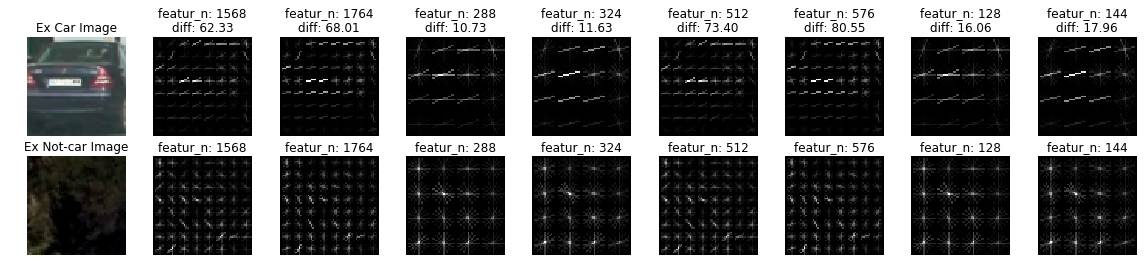

In [124]:
box_plot_data = HOG_comparison(cars[2000], notcars[9000],notcars)

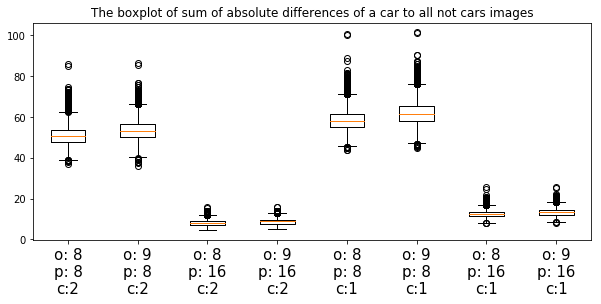

In [141]:
fig, ax1 = plt.subplots(figsize=(10, 4))
ax1.boxplot(box_plot_data);
ax1.set_title("The boxplot of sum of absolute differences of a car to all not cars images")
randomDists = ["o: 8\np: 8\nc:2", "o: 9\np: 8\nc:2","o: 8\np: 16\nc:2","o: 9\np: 16\nc:2"
               ,"o: 8\np: 8\nc:1","o: 9\np: 8\nc:1","o: 8\np: 16\nc:1","o: 9\np: 16\nc:1",]
ax1.set_xticklabels(randomDists, rotation=0, fontsize=15)
plt.show()

## Test for bin_spatial

shape of spatial features (768,)


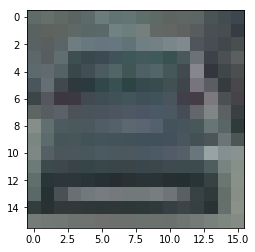

In [110]:
test_img_path = ".//test_images//image0004.png"
car_img = mpimg.imread(test_img_path)

# image of spatial features
bin_spatial_hist = bin_spatial(car_img, size=(16, 16))
print ("shape of spatial features",bin_spatial_hist.shape)
plt.imshow(bin_spatial_hist.reshape(16, 16, 3))

## Test for color_hist

shape of color features (96,)


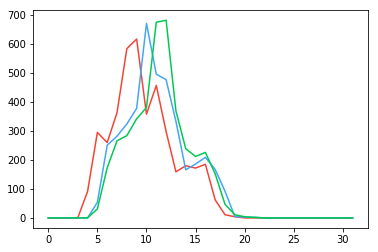

In [146]:
# image of color features
color_hist_feature = color_hist(RGB_img, nbins=32)
print ("shape of color features",color_hist_feature.shape)
plt.plot(color_hist_feature[:32], color="#F44336") # the sum will be the height * width * 3
plt.plot(color_hist_feature[32:64], color="#42A5F5")
plt.plot(color_hist_feature[64:96], color="#00C853")

The `get_img_features` function extracl HOG, color histogram, binned spatial features from images.

In [147]:
def get_img_features(img
                    , hist_bins
                    , orient, pix_per_cell, cell_per_block, hog_channel, spatial_size
                    , color_space='RGB'
                    , spatial_feat = True, hist_feat = True, hog_feat = True):
    """
    This method extracts features from a image
    
    * parameter:
    
    -- img: uint8, ndarray
           A 2-D, 3-D matrix.
           
    -- spatial_feat: boolean
           extract spatial features if True
           Parameter for spatial feature.
           
    -- hist_feat: boolean
           extract color histogram features if True
           
    -- hog_feat: boolean
           extract HOG features if True
           Parameter for HOG feature.
           Parameter for color histogram feature.
           
    -- hist_bins: int or sequence
           If bins is an int, it defines the number of equal-width bins in the given range (10, by default). 
           If bins is a sequence, it defines the bin edges, including the rightmost edge, allowing for non-uniform bin widths.
           Parameter for color histogram feature.
           
    -- orient: int
           Number of orientation bins.
           Parameter for HOG feature.
           
    -- pix_per_cell: int 
           Size (in pixels) of a cell.
           Parameter for HOG feature.
           
    -- cell_per_block: int
           Number of cells in each block.
           Parameter for HOG feature.
           
    -- hog_channel: string
           If the input is `ALL`, the method will extract the HOG for each channel(RGB) respectively. 
           Otherwise, it will turn the image to grayscale and extract features.        
           Parameter for HOG feature.

    -- color_space: string
           the color space, default is RGB. 
           Parameter for HOG feature.
        
    -- spatial_size: tuple of two int
           The new height and width of compressed image. 
           Parameter for spatial feature.
        
    * Returns
    
    -- features: list
           A list of extracted features.
    """
    
    feature_img = None
    
    if color_space == 'RGB':
        feature_img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)        
    elif color_space == 'HSV':
        feature_img = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    elif color_space == 'LUV':
        feature_img = cv2.cvtColor(img, cv2.COLOR_BGR2LUV)
    elif color_space == 'HLS':
        feature_img = cv2.cvtColor(img, cv2.COLOR_BGR2HLS)
    elif color_space == 'YUV':
        feature_img = cv2.cvtColor(img, cv2.COLOR_BGR2YUV)
    elif color_space == 'YCrCb':
        feature_img = cv2.cvtColor(img, cv2.COLOR_BGR2YCrCb)
    elif color_space == 'LAB':
        feature_img = cv2.cvtColor(img, cv2.COLOR_BGR2LAB)
    else:
        feature_img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)      
    
    features = []
    if spatial_feat == True:
        spatial_features = bin_spatial(feature_img, size=spatial_size)
        features.append(spatial_features)
        
    if hist_feat == True:
        hist_features = color_hist(feature_img, nbins=hist_bins)
        features.append(hist_features)
    
    if hog_feat == True:
        if hog_channel == 'ALL':
            hog_features = []
            for channel in range(feature_img.shape[2]):
                channel_feature = get_hog_features(feature_img[:,:,channel], 
                                                    orient, pix_per_cell, cell_per_block, 
                                                    vis=False, feature_vec=False).ravel()
                hog_features.append(channel_feature) 
            hog_features = np.array(hog_features)
        else:
            feature_img = cv2.cvtColor(feature_img, cv2.COLOR_RGB2GRAY)
            hog_features = get_hog_features(feature_img, orient, 
                            pix_per_cell, cell_per_block, vis=False, feature_vec=False)

        features.append(hog_features)
    return features

## Test on `get_img_features()`

In [154]:
test_img_path = ".//test_images//image0194.png"
BGR_img = mpimg.imread(test_img_path)

img_features = get_img_features(img = BGR_img
                                , spatial_feat = True, hist_feat = True, hog_feat = True
                                , hist_bins = 32
                                , spatial_size = (16, 16)
                                , orient = 9 , pix_per_cell = 8, cell_per_block = 1, hog_channel = 'ALL', color_space='RGB')

In [155]:
# img_features[0]: spatial features
# img_features[1]: color histogram features
# img_features[2]: HOG features
ravel_img_features = np.concatenate((img_features[0].ravel(), img_features[1].ravel(), img_features[2].ravel()))

In [156]:
print ('shape of spatial features: ', img_features[0].shape)
print ("range of spatial features: ", np.min(img_features[0]),"~", np.max(img_features[0]))

shape of spatial features:  (768,)
range of spatial features:  0.117647 ~ 0.918628


In [157]:
print ('shape of color histogram features: ', img_features[1].shape)
print ("range of color histogram features", np.min(img_features[1]),"~", np.max(img_features[1]))

shape of color histogram features:  (96,)
range of color histogram features 0 ~ 4096


In [158]:
print ('shape of HOG features: ', img_features[2].shape)
print ("range of HOG features", np.min(img_features[2]),"~", np.max(img_features[2]))

shape of HOG features:  (3, 576)
range of HOG features 0.0 ~ 0.966946144042


In [159]:
print ("feature number of an image :", ravel_img_features.shape[0])

feature number of an image : 2592


## Test on car and non-car data

In [20]:
car_features = get_img_features(img = cars[1520]
                                , spatial_feat = True, hist_feat = True, hog_feat = True
                                , hist_bins = 32
                                , spatial_size = (16, 16)
                                , orient = 8 , pix_per_cell = 8, cell_per_block = 1, hog_channel = 0, color_space='RGB')
print ('shape of spatial features: ', car_features[0].shape)
print ("range of spatial features: ", np.min(car_features[0]),"~", np.max(car_features[0]))
print ('shape of color histogram features: ', car_features[1].shape)
print ("range of color histogram features", np.min(car_features[1]),"~", np.max(car_features[1]))
print ('shape of HOG features: ', car_features[2].shape)
print ("range of HOG features", np.min(car_features[2]),"~", np.max(car_features[2]))

ravel_car_features = np.concatenate((car_features[0].ravel(), car_features[1].ravel(), car_features[2].ravel()))
print ("feature number of a car image :", ravel_car_features.shape[0])

shape of spatial features:  (16, 16, 3)
range of spatial features:  35 ~ 202
shape of color histogram features:  (3, 32)
range of color histogram features 0 ~ 574
shape of HOG features:  (8, 8, 1, 1, 8)
range of HOG features 0.0 ~ 0.696373535673
feature number of a car image : 1376


In [21]:
notcar_features = get_img_features(img = notcars[1520]
                                , spatial_feat = True, hist_feat = True, hog_feat = True
                                , hist_bins = 32
                                , spatial_size = (16, 16)
                                , orient = 8 , pix_per_cell = 8, cell_per_block = 1, hog_channel = 0, color_space='RGB')
print ('shape of spatial features: ', notcar_features[0].shape)
print ("range of spatial features: ", np.min(notcar_features[0]),"~", np.max(notcar_features[0]))
print ('shape of color histogram features: ', notcar_features[1].shape)
print ("range of color histogram features", np.min(notcar_features[1]),"~", np.max(notcar_features[1]))
print ('shape of HOG features: ', notcar_features[2].shape)
print ("range of HOG features", np.min(notcar_features[2]),"~", np.max(notcar_features[2]))

ravel_notcar_features = np.concatenate((notcar_features[0].ravel(), notcar_features[1].ravel(), notcar_features[2].ravel()))
print ("feature number of a car image :", ravel_notcar_features.shape[0])

shape of spatial features:  (16, 16, 3)
range of spatial features:  28 ~ 255
shape of color histogram features:  (3, 32)
range of color histogram features 0 ~ 1489
shape of HOG features:  (8, 8, 1, 1, 8)
range of HOG features 0.0 ~ 0.93889318102
feature number of a car image : 1376


# Explore Color Spaces
* This part mainly focuses on the exploration of distribuition of the pixel over different color space and decide which one to use.

In [22]:
! python color_space_exploration.py

Figure(800x800)
Figure(800x800)
Figure(800x800)
Figure(800x800)
Figure(800x800)
Figure(800x800)
Figure(800x800)


In [170]:
def plot3d(pixels, colors_rgb
            , axis_labels=list("RGB")
            , axis_limits=((0, 255), (0, 255), (0, 255))):
    """Plot pixels in 3D."""

    # Create figure and 3D axes
    fig = plt.figure(figsize=(8, 8))
    ax = Axes3D(fig)

    # Set axis limits
    ax.set_xlim(*axis_limits[0])
    ax.set_ylim(*axis_limits[1])
    ax.set_zlim(*axis_limits[2])

    # Set axis labels and sizes
    ax.tick_params(axis='both', which='major', labelsize=14, pad=8)
    ax.set_xlabel(axis_labels[0], fontsize=16, labelpad=16)
    ax.set_ylabel(axis_labels[1], fontsize=16, labelpad=16)
    ax.set_zlabel(axis_labels[2], fontsize=16, labelpad=16)

    # Plot pixel values with colors given in colors_rgb
    ax.scatter(
        pixels[:, :, 0].ravel(),
        pixels[:, :, 1].ravel(),
        pixels[:, :, 2].ravel(),
        c=colors_rgb.reshape((-1, 3)), edgecolors='none')


    return ax  # return Axes3D object for further manipulation

## Test on `plot3d()`

In [295]:
def draw_color_hist(img, nocar_img):
    index = np.arange(32)
    bar_width = 1
    opacity = 0.5
    car_color = 'r'
    nocar_color = 'g'
    
    # car
    # Convert subsampled image to desired color space(s)
    img_small_RGB = img * 255  # OpenCV uses BGR  range(0~255), matplotlib likes RGB range(0~1)
#     rescalered_img = (img - np.min(img))/(np.max(img) - np.min(img))
    img_small_HSV = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
    img_small_LUV = cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
    rescalered_LUV = (img_small_LUV - np.min(img_small_LUV))/(np.max(img_small_LUV) - np.min(img_small_LUV))
    img_small_HLS = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    img_small_YUV = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
    img_small_YCrCb = cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    img_small_LAB = cv2.cvtColor(img, cv2.COLOR_RGB2LAB)
    rescalered_LAB = (img_small_LAB - np.min(img_small_LAB))/(np.max(img_small_LAB) - np.min(img_small_LAB))

    RGB_hist = color_hist(img_small_RGB)
    HSV_hist = color_hist(img_small_HSV)
    LUV_hist = color_hist(img_small_LUV)
    HLS_hist = color_hist(img_small_HLS)
    YUV_hist = color_hist(img_small_YUV)
    YCrCb_hist = color_hist(img_small_YCrCb)
    LAB_hist = color_hist(img_small_LAB)
    
    # no car
    # Read a color image
    # Convert subsampled image to desired color space(s)
    nocar_img_small_RGB = nocar_img * 255  # OpenCV uses BGR  range(0~255), matplotlib likes RGB range(0~1)
    nocar_img_small_HSV = cv2.cvtColor(nocar_img, cv2.COLOR_RGB2HSV)
    nocar_img_small_LUV = cv2.cvtColor(nocar_img, cv2.COLOR_RGB2LUV)
    nocar_rescalered_LUV = (nocar_img_small_LUV - np.min(nocar_img_small_LUV))/(np.max(nocar_img_small_LUV) - np.min(nocar_img_small_LUV))
    nocar_img_small_HLS = cv2.cvtColor(nocar_img, cv2.COLOR_RGB2HLS)
    nocar_img_small_YUV = cv2.cvtColor(nocar_img, cv2.COLOR_RGB2YUV)
    nocar_img_small_YCrCb = cv2.cvtColor(nocar_img, cv2.COLOR_RGB2YCrCb)
    nocar_img_small_LAB = cv2.cvtColor(nocar_img, cv2.COLOR_RGB2LAB)
    nocar_rescalered_LAB = (nocar_img_small_LAB - np.min(nocar_img_small_LAB))/(np.max(nocar_img_small_LAB) - np.min(nocar_img_small_LAB))
    
    nocar_RGB_hist = color_hist(nocar_img_small_RGB)
    nocar_HSV_hist = color_hist(nocar_img_small_HSV)
    nocar_LUV_hist = color_hist(nocar_img_small_LUV)
    nocar_HLS_hist = color_hist(nocar_img_small_HLS)
    nocar_YUV_hist = color_hist(nocar_img_small_YUV)
    nocar_YCrCb_hist = color_hist(nocar_img_small_YCrCb)
    nocar_LAB_hist = color_hist(nocar_img_small_LAB)    
    
    f, ((ax1, ax1_nocar, ax2, ax3, ax4), (ax5, ax5_nocar, ax6, ax7, ax8),
    (ax9, ax9_nocar, ax10, ax11, ax12), (ax13, ax13_nocar, ax14, ax15, ax16),
   (ax17, ax17_nocar, ax18, ax19, ax20), (ax21, ax21_nocar, ax22, ax23, ax24),
   (ax25, ax25_nocar, ax26, ax27, ax28)) = plt.subplots(7, 5, figsize=(20, 20))

    f.tight_layout()

    # RGB
    ax1.imshow(img)
    ax1.set_title('RGB', fontsize=20)
    ax1.axis('off')

    ax1_nocar.imshow(nocar_img)
    ax1_nocar.set_title('RGB', fontsize=20)
    ax1_nocar.axis('off')

    ax2.bar(index, RGB_hist[:32], bar_width,alpha=opacity, color=car_color)
    ax2.bar(index, nocar_RGB_hist[:32], bar_width,alpha=opacity, color=nocar_color)
    ax2.set_title('RGB (R)', fontsize=20)

    ax3.bar(index, RGB_hist[32:64], bar_width,alpha=opacity, color=car_color)
    ax3.bar(index, nocar_RGB_hist[32:64], bar_width,alpha=opacity, color=nocar_color)
    ax3.set_title('RGB (G)', fontsize=20)

    ax4.bar(index, RGB_hist[64:96], bar_width,alpha=opacity, color=car_color)
    ax4.bar(index, nocar_RGB_hist[64:96], bar_width,alpha=opacity, color=nocar_color)
    ax4.set_title('RGB (B)', fontsize=20)

    # HSV
    ax5.imshow(img_small_HSV)
    ax5.set_title('HSV', fontsize=20)
    ax5.axis('off')

    ax5_nocar.imshow(nocar_img_small_HSV)
    ax5_nocar.set_title('HSV', fontsize=20)
    ax5_nocar.axis('off')

    ax6.bar(index, HSV_hist[:32], bar_width,alpha=opacity, color=car_color)
    ax6.bar(index, nocar_HSV_hist[:32], bar_width,alpha=opacity, color=nocar_color)
    ax6.set_title('HSV (H)', fontsize=20)

    ax7.bar(index, HSV_hist[32:64], bar_width,alpha=opacity, color=car_color) 
    ax7.bar(index, nocar_HSV_hist[32:64], bar_width,alpha=opacity, color=nocar_color)
    ax7.set_title('HSV (S)', fontsize=20)

    ax8.bar(index, HSV_hist[64:], bar_width,alpha=opacity, color=car_color)
    ax8.bar(index, nocar_HSV_hist[64:], bar_width,alpha=opacity, color=nocar_color)
    ax8.set_title('HSV (V)', fontsize=20)

    # LUV
    ax9.imshow(rescalered_LUV)
    ax9.set_title('LUV', fontsize=20)
    ax9.axis('off')

    ax9_nocar.imshow(nocar_rescalered_LUV)
    ax9_nocar.set_title('LUV', fontsize=20)
    ax9_nocar.axis('off')

    ax10.bar(index, LUV_hist[:32], bar_width,alpha=opacity, color=car_color) 
    ax10.bar(index, nocar_LUV_hist[:32], bar_width,alpha=opacity, color=nocar_color)
    ax10.set_title('LUV (L)', fontsize=20)

    ax11.bar(index, LUV_hist[32:64], bar_width,alpha=opacity, color=car_color)
    ax11.bar(index, nocar_LUV_hist[32:64], bar_width,alpha=opacity, color=nocar_color)
    ax11.set_title('LUV (U)', fontsize=20)

    ax12.bar(index, LUV_hist[64:], bar_width,alpha=opacity, color=car_color)
    ax12.bar(index, nocar_LUV_hist[64:], bar_width,alpha=opacity, color=nocar_color)
    ax12.set_title('LUV (V)', fontsize=20)

    # HLS
    ax13.imshow(img_small_HLS)
    ax13.set_title('HLS', fontsize=20)
    ax13.axis('off')

    ax13_nocar.imshow(nocar_img_small_HLS)
    ax13_nocar.set_title('HLS', fontsize=20)
    ax13_nocar.axis('off')

    ax14.bar(index, HLS_hist[:32], bar_width,alpha=opacity, color=car_color) 
    ax14.bar(index, nocar_HLS_hist[:32], bar_width,alpha=opacity, color=nocar_color)
    ax14.set_title('HLS (H)', fontsize=20)

    ax15.bar(index, HLS_hist[32:64], bar_width,alpha=opacity, color=car_color)
    ax15.bar(index, nocar_HLS_hist[32:64], bar_width,alpha=opacity, color=nocar_color)
    ax15.set_title('HLS (L)', fontsize=20)

    ax16.bar(index, HLS_hist[64:], bar_width,alpha=opacity, color=car_color)
    ax16.bar(index, nocar_HLS_hist[64:], bar_width,alpha=opacity, color=nocar_color)
    ax16.set_title('HLS (S)', fontsize=20)

    # YUV
    ax17.imshow(img_small_YUV)
    ax17.set_title('YUV', fontsize=20)
    ax17.axis('off')

    ax17_nocar.imshow(nocar_img_small_YUV)
    ax17_nocar.set_title('YUV', fontsize=20)
    ax17_nocar.axis('off')

    ax18.bar(index, YUV_hist[:32], bar_width,alpha=opacity, color=car_color) 
    ax18.bar(index, nocar_YUV_hist[:32], bar_width,alpha=opacity, color=nocar_color)
    ax18.set_title('YUV (Y)', fontsize=20)

    ax19.bar(index, YUV_hist[32:64], bar_width,alpha=opacity, color=car_color)
    ax19.bar(index, nocar_YUV_hist[32:64], bar_width,alpha=opacity, color=nocar_color)
    ax19.set_title('YUV (U)', fontsize=20)

    ax20.bar(index, YUV_hist[64:], bar_width,alpha=opacity, color=car_color)
    ax20.bar(index, nocar_YUV_hist[64:], bar_width,alpha=opacity, color=nocar_color)
    ax20.set_title('YUV (V)', fontsize=20)

    # YCrCb
    ax21.imshow(img_small_YCrCb)
    ax21.set_title('YCrCb', fontsize=20)
    ax21.axis('off')

    ax21_nocar.imshow(nocar_img_small_YCrCb)
    ax21_nocar.set_title('YCrCb', fontsize=20)
    ax21_nocar.axis('off')

    ax22.bar(index, YCrCb_hist[:32], bar_width,alpha=opacity, color=car_color) 
    ax22.bar(index, nocar_YCrCb_hist[:32], bar_width,alpha=opacity, color=nocar_color)
    ax22.set_title('YCrCb (Y)', fontsize=20)

    ax23.bar(index, YCrCb_hist[32:64], bar_width,alpha=opacity, color=car_color)
    ax23.bar(index, nocar_YCrCb_hist[32:64], bar_width,alpha=opacity, color=nocar_color)
    ax23.set_title('YCrCb (CR)', fontsize=20)

    ax24.bar(index, YCrCb_hist[64:], bar_width,alpha=opacity, color=car_color)
    ax24.bar(index, nocar_YCrCb_hist[64:], bar_width,alpha=opacity, color=nocar_color)
    ax24.set_title('YCrCb (CB)', fontsize=20)

    # LAB
    ax25.imshow(rescalered_LAB)
    ax25.set_title('LAB', fontsize=20)
    ax25.axis('off')

    ax25_nocar.imshow(nocar_rescalered_LAB)
    ax25_nocar.set_title('LAB', fontsize=20)
    ax25_nocar.axis('off')
 
    ax26.bar(index, LAB_hist[:32], bar_width,alpha=opacity, color=car_color)
    ax26.bar(index, nocar_LAB_hist[:32], bar_width,alpha=opacity, color=nocar_color)
    ax26.set_title('LAB (L)', fontsize=20)

    ax27.bar(index, LAB_hist[32:64], bar_width,alpha=opacity, color=car_color)
    ax27.bar(index, nocar_LAB_hist[32:64], bar_width,alpha=opacity, color=nocar_color)
    ax27.set_title('LAB (A)', fontsize=20)

    ax28.bar(index, LAB_hist[64:], bar_width,alpha=opacity, color=car_color)
    ax28.bar(index, nocar_LAB_hist[64:], bar_width,alpha=opacity, color=nocar_color)
    ax28.set_title('LAB (B)', fontsize=20)

    plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

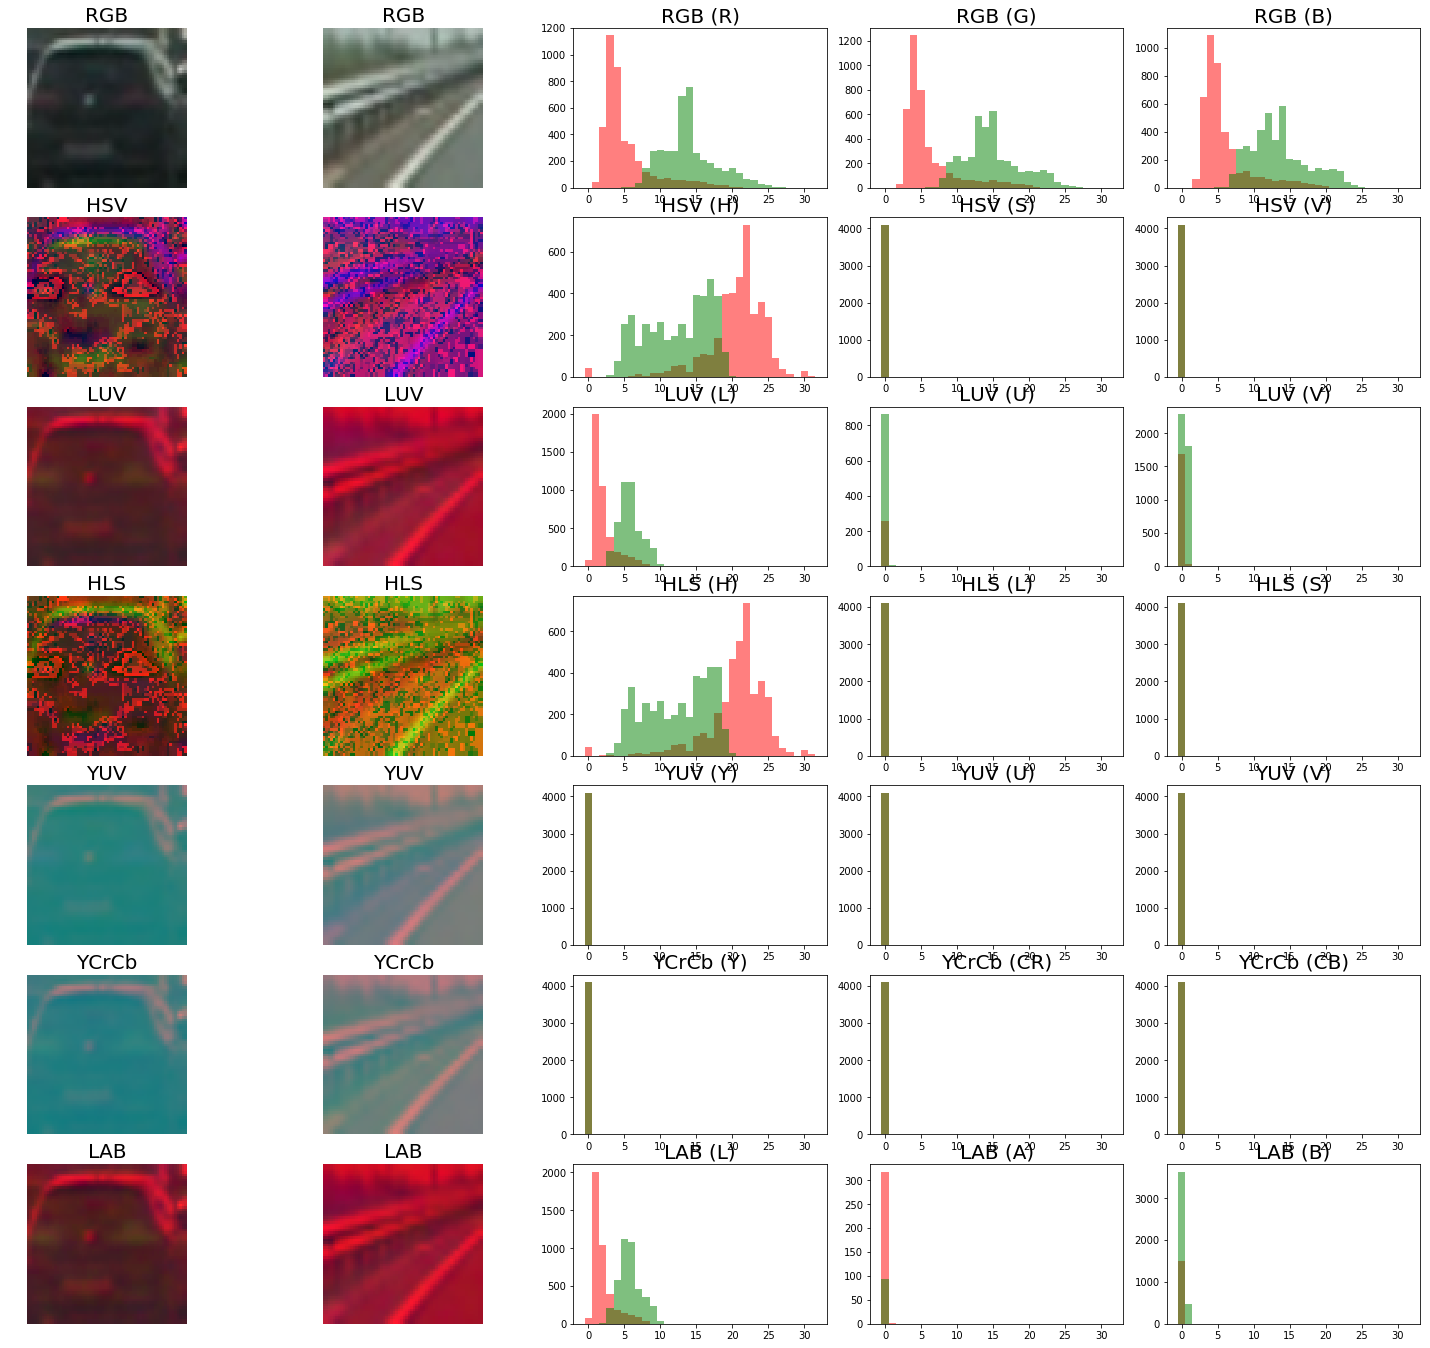

In [296]:
test_img_path = ".//test_images//image0194.png"
img = mpimg.imread(test_img_path)
nocar_test_img_path = ".//test_images//image8.png"
nocar_img = mpimg.imread(nocar_test_img_path)
# draw_color_hist(img, nocar_img)
draw_color_hist(cars[1000], nocar_img)

In [212]:
# Read a color image
test_img_path = ".//test_images//test1.jpg"
img = mpimg.imread(test_img_path)

# Select a small fraction of pixels to plot by subsampling it
scale = max(img.shape[0], img.shape[1], 64) / 64  # at most 64 rows and columns
img_small = cv2.resize(img, (np.int(img.shape[1] / scale), np.int(img.shape[0] / scale)), interpolation=cv2.INTER_NEAREST)

# Convert subsampled image to desired color space(s)
img_small_RGB = img_small  # OpenCV uses BGR, matplotlib likes RGB
img_small_HSV = cv2.cvtColor(img_small, cv2.COLOR_RGB2HSV)
img_small_LUV = cv2.cvtColor(img_small, cv2.COLOR_RGB2LUV)
img_small_HLS = cv2.cvtColor(img_small, cv2.COLOR_RGB2HLS)
img_small_YUV = cv2.cvtColor(img_small, cv2.COLOR_RGB2YUV)
img_small_YCrCb = cv2.cvtColor(img_small, cv2.COLOR_RGB2YCrCb)
img_small_LAB = cv2.cvtColor(img_small, cv2.COLOR_RGB2LAB)
img_small_rgb = img_small_RGB / 255.  # scaled to [0, 1], only for plotting

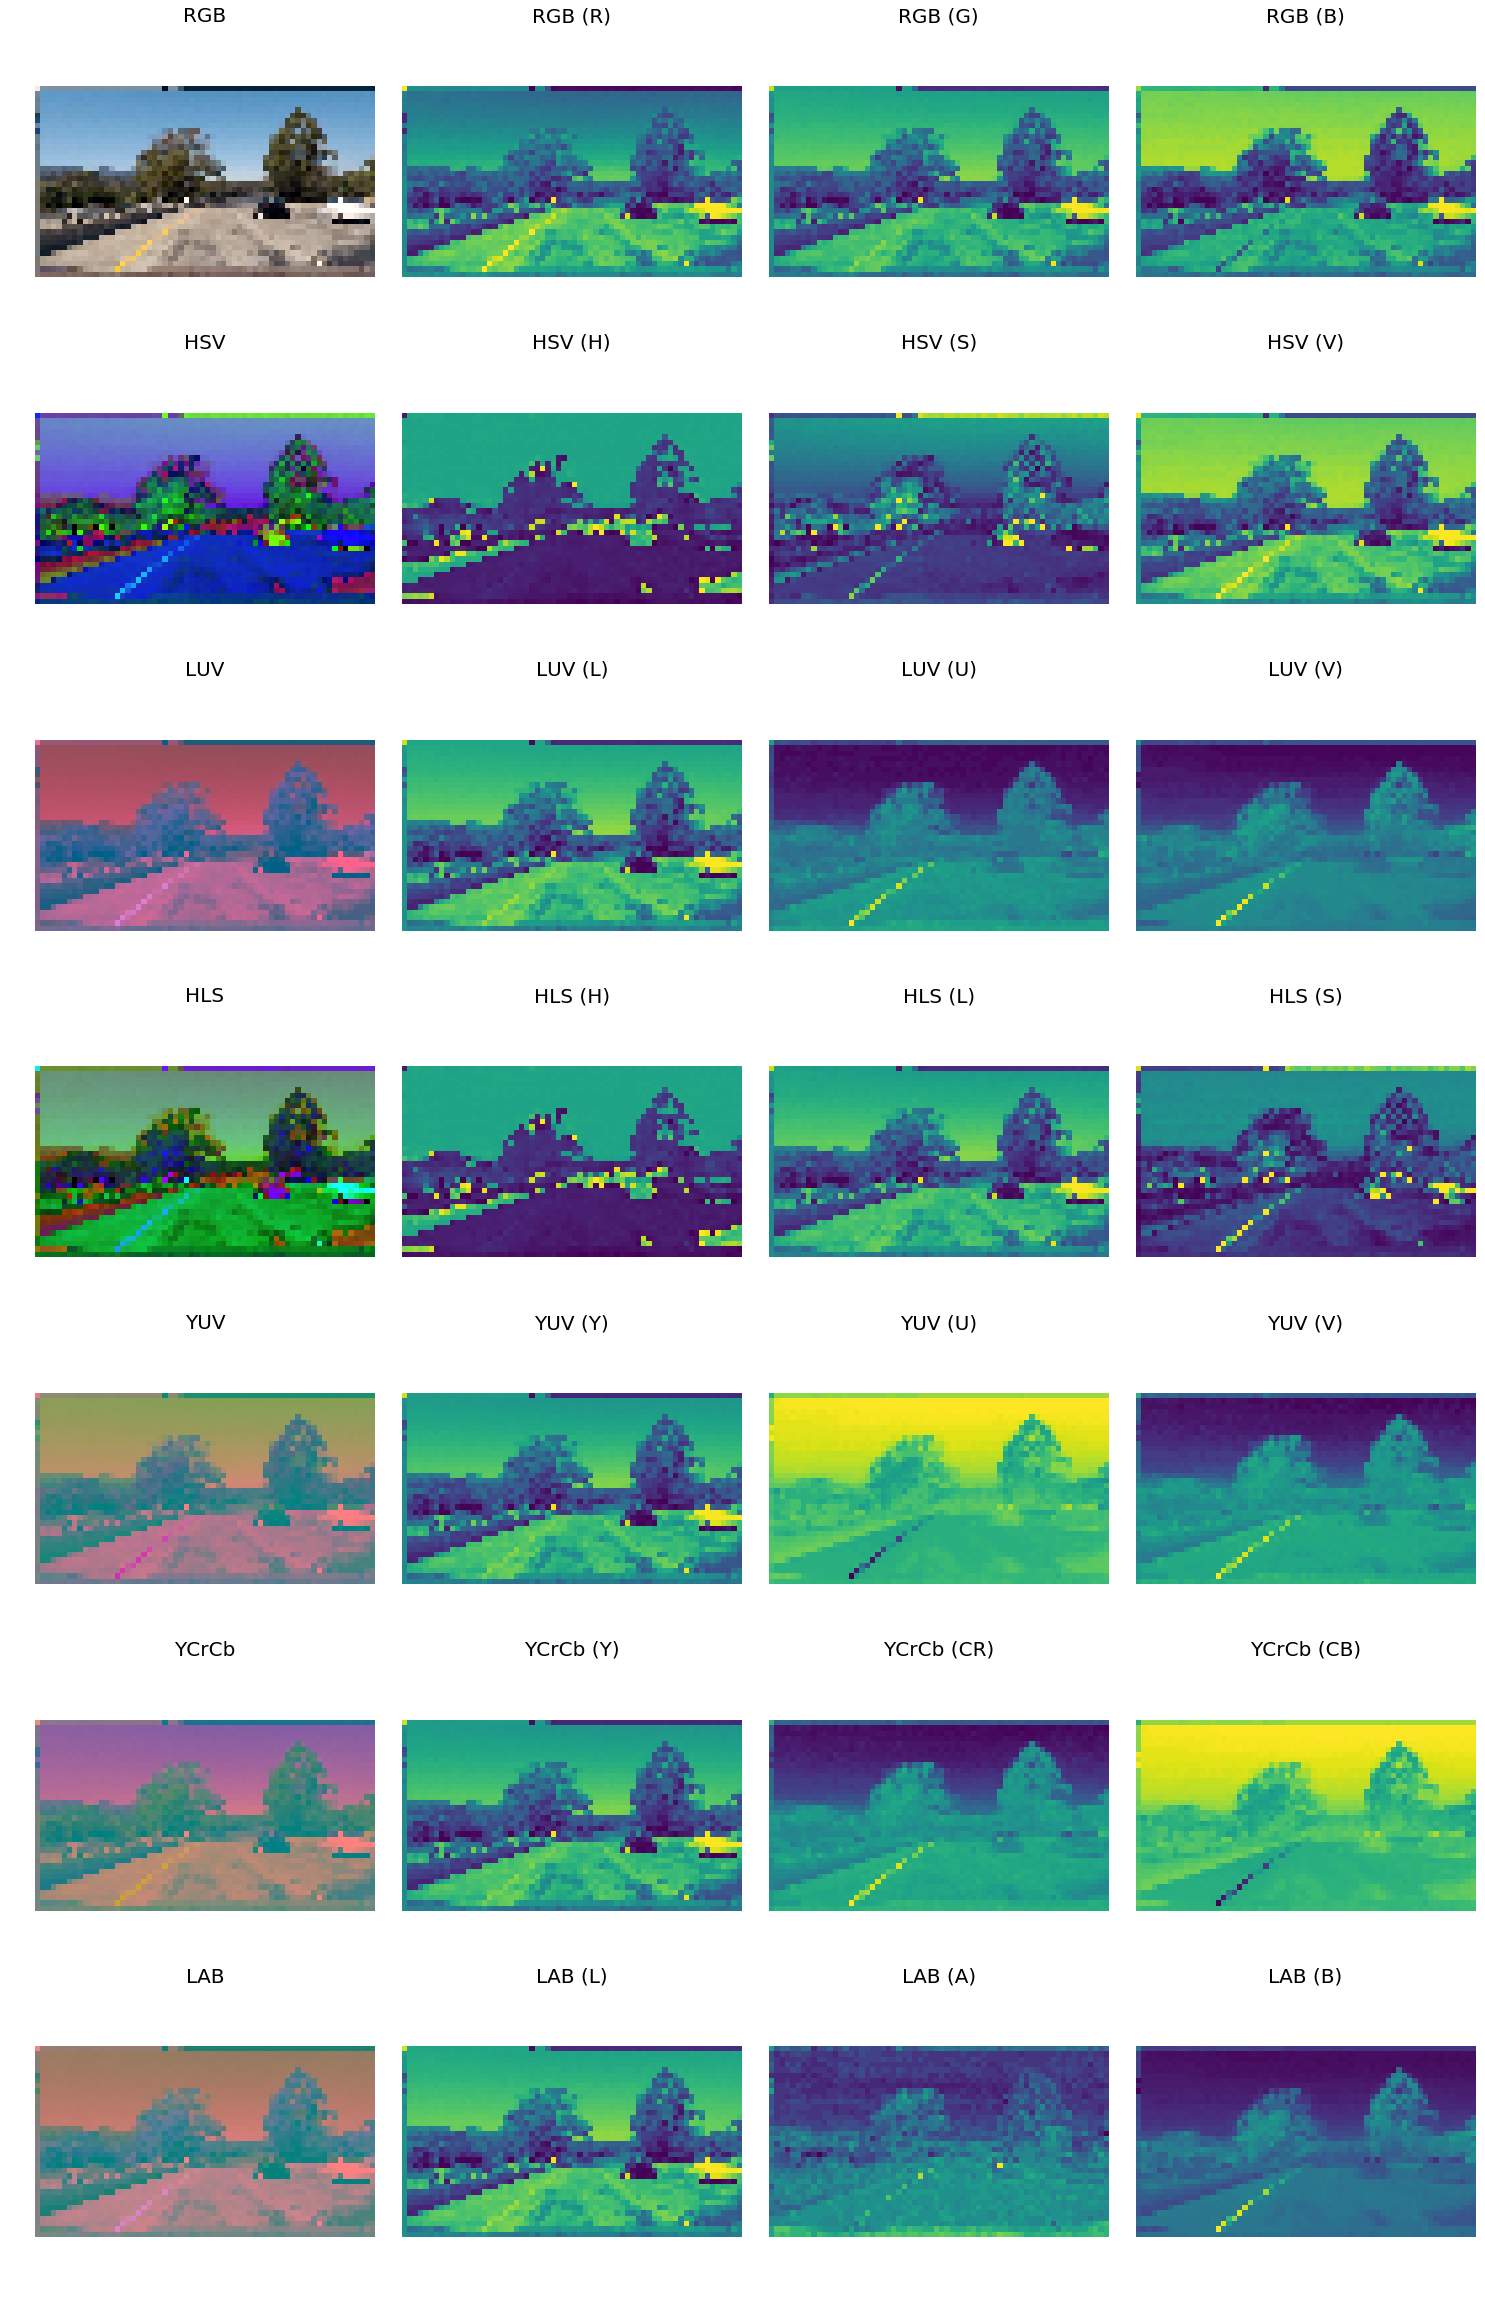

In [213]:
f, ((ax1, ax2, ax3, ax4), (ax5, ax6, ax7, ax8),
    (ax9, ax10, ax11, ax12), (ax13, ax14, ax15, ax16),
   (ax17, ax18, ax19, ax20), (ax21, ax22, ax23, ax24),
   (ax25, ax26, ax27, ax28)) = plt.subplots(7, 4, figsize=(20, 35), sharex=True, sharey=True)
f.tight_layout()

# RGB
ax1.imshow(img_small_RGB)
ax1.set_title('RGB', fontsize=20)
ax1.axis('off')
ax2.imshow(img_small_RGB[:,:,0])
ax2.set_title('RGB (R)', fontsize=20)
ax2.axis('off')
ax3.imshow(img_small_RGB[:,:,1])
ax3.set_title('RGB (G)', fontsize=20)
ax3.axis('off')
ax4.imshow(img_small_RGB[:,:,2])
ax4.set_title('RGB (B)', fontsize=20)
ax4.axis('off')

# HSV
ax5.imshow(img_small_HSV)
ax5.set_title('HSV', fontsize=20)
ax5.axis('off')
ax6.imshow(img_small_HSV[:,:,0])
ax6.set_title('HSV (H)', fontsize=20)
ax6.axis('off')
ax7.imshow(img_small_HSV[:,:,1])
ax7.set_title('HSV (S)', fontsize=20)
ax7.axis('off')
ax8.imshow(img_small_HSV[:,:,2])
ax8.set_title('HSV (V)', fontsize=20)
ax8.axis('off')

# LUV
ax9.imshow(img_small_LUV)
ax9.set_title('LUV', fontsize=20)
ax9.axis('off')
ax10.imshow(img_small_LUV[:,:,0])
ax10.set_title('LUV (L)', fontsize=20)
ax10.axis('off')
ax11.imshow(img_small_LUV[:,:,1])
ax11.set_title('LUV (U)', fontsize=20)
ax11.axis('off')
ax12.imshow(img_small_LUV[:,:,2])
ax12.set_title('LUV (V)', fontsize=20)
ax12.axis('off')

# HLS
ax13.imshow(img_small_HLS)
ax13.set_title('HLS', fontsize=20)
ax13.axis('off')
ax14.imshow(img_small_HLS[:,:,0])
ax14.set_title('HLS (H)', fontsize=20)
ax14.axis('off')
ax15.imshow(img_small_HLS[:,:,1])
ax15.set_title('HLS (L)', fontsize=20)
ax15.axis('off')
ax16.imshow(img_small_HLS[:,:,2])
ax16.set_title('HLS (S)', fontsize=20)
ax16.axis('off')

# YUV
ax17.imshow(img_small_YUV)
ax17.set_title('YUV', fontsize=20)
ax17.axis('off')
ax18.imshow(img_small_YUV[:,:,0])
ax18.set_title('YUV (Y)', fontsize=20)
ax18.axis('off')
ax19.imshow(img_small_YUV[:,:,1])
ax19.set_title('YUV (U)', fontsize=20)
ax19.axis('off')
ax20.imshow(img_small_YUV[:,:,2])
ax20.set_title('YUV (V)', fontsize=20)
ax20.axis('off')

# YCrCb
ax21.imshow(img_small_YCrCb)
ax21.set_title('YCrCb', fontsize=20)
ax21.axis('off')
ax22.imshow(img_small_YCrCb[:,:,0])
ax22.set_title('YCrCb (Y)', fontsize=20)
ax22.axis('off')
ax23.imshow(img_small_YCrCb[:,:,1])
ax23.set_title('YCrCb (CR)', fontsize=20)
ax23.axis('off')
ax24.imshow(img_small_YCrCb[:,:,2])
ax24.set_title('YCrCb (CB)', fontsize=20)
ax24.axis('off')

# LAB
ax25.imshow(img_small_LAB)
ax25.set_title('LAB', fontsize=20)
ax25.axis('off')
ax26.imshow(img_small_LAB[:,:,0])
ax26.set_title('LAB (L)', fontsize=20)
ax26.axis('off')
ax27.imshow(img_small_LAB[:,:,1])
ax27.set_title('LAB (A)', fontsize=20)
ax27.axis('off')
ax28.imshow(img_small_LAB[:,:,2])
ax28.set_title('LAB (B)', fontsize=20)
ax28.axis('off')

plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

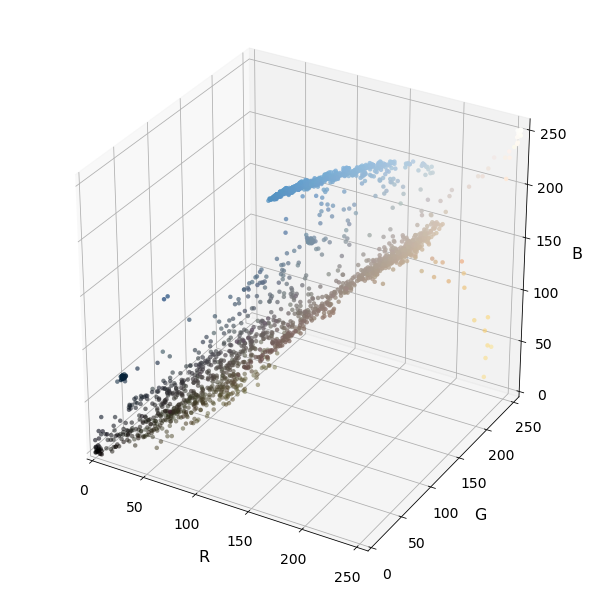

In [181]:
# Plot and show
plot3d(img_small_RGB, img_small_rgb)
plt.show()

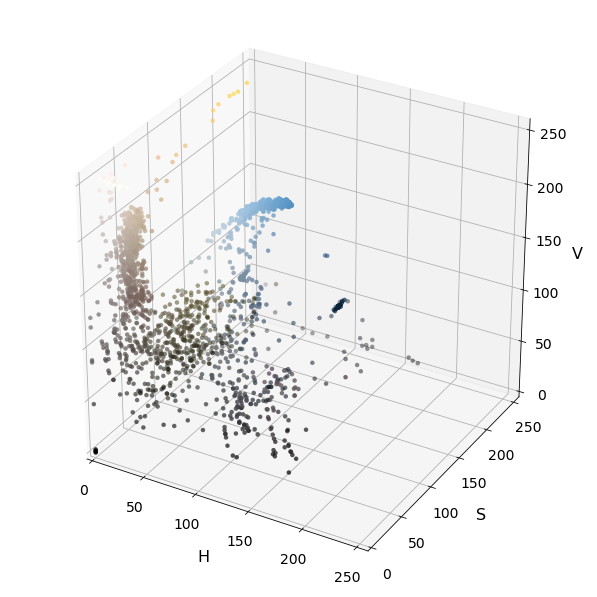

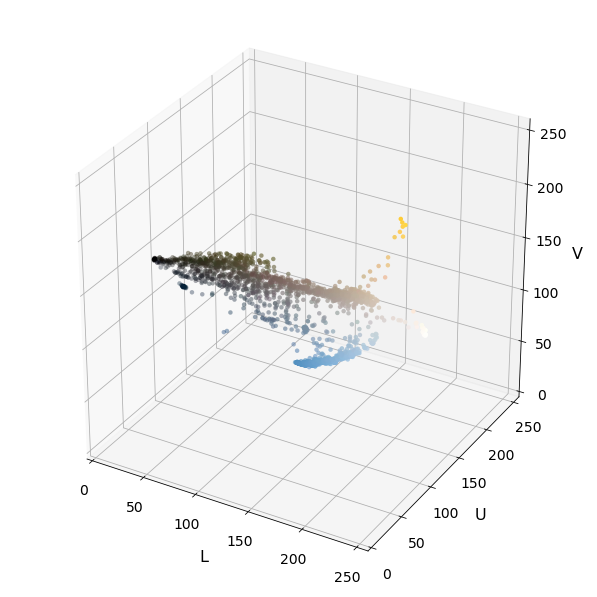

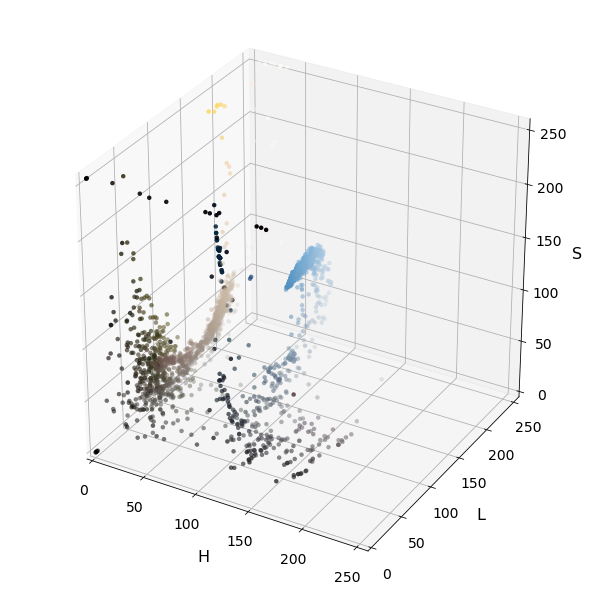

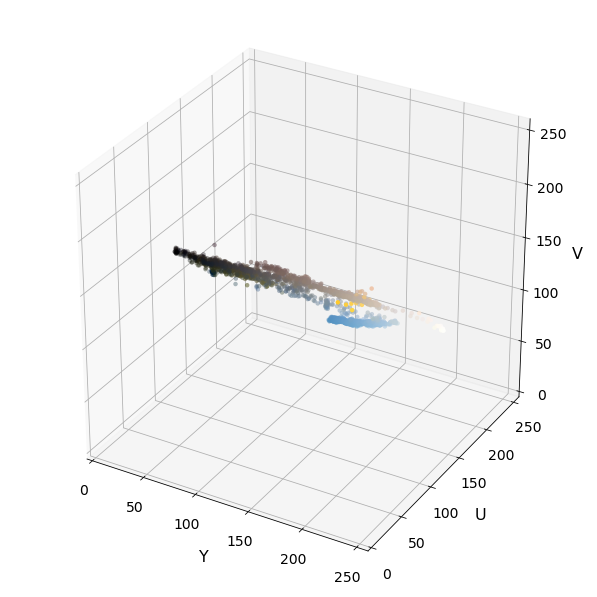

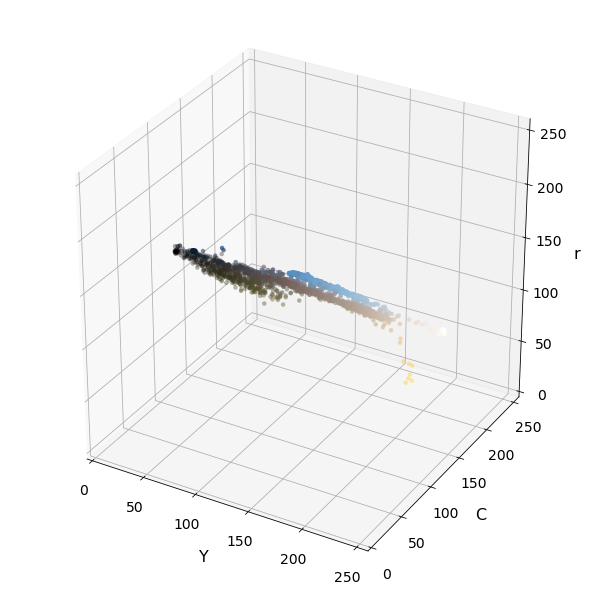

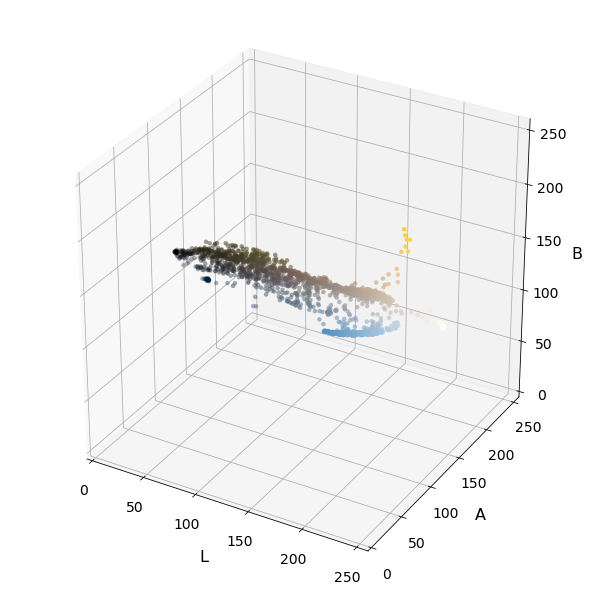

In [182]:
plot3d(img_small_HSV, img_small_rgb, axis_labels=list("HSV"))
plt.show()

plot3d(img_small_LUV, img_small_rgb, axis_labels=list("LUV"))
plt.show()

plot3d(img_small_HLS, img_small_rgb, axis_labels=list("HLS"))
plt.show()

plot3d(img_small_YUV, img_small_rgb, axis_labels=list("YUV"))
plt.show()

plot3d(img_small_YCrCb, img_small_rgb, axis_labels=list("YCrCb"))
plt.show()

plot3d(img_small_LAB, img_small_rgb, axis_labels=list("LAB"))
plt.show()

# Feature Extraction

In [364]:
color_space = 'YUV' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 15  # HOG orientations
pix_per_cell = 8 # HOG pixels per cell
cell_per_block = 2 # HOG cells per block
hog_channel = "ALL" # Can be 0, 1, 2, or "ALL"
spatial_size = (32, 32) # Spatial binning dimensions
hist_bins = 32    # Number of histogram bins
spatial_feat = True # Spatial features on or off
hist_feat = True # Histogram features on or off
hog_feat = True # HOG features on or off

car_features = extract_features(cars, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)
notcar_features = extract_features(notcars, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)


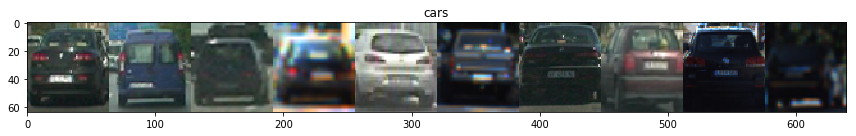

In [355]:
display_imgs(np.array(cars)[np.random.choice(len(cars), 10)], 10, (64,64), (12,2), "cars")

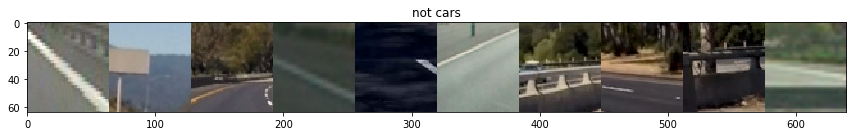

In [361]:
display_imgs(np.array(notcars)[np.random.choice(len(notcars), 10)], 10, (64,64), (12,2), "not cars")

# Classifier Building
The following code chunk creates feature list for the training data. Feature list is normolized by the `StandardScaler()` method from `sklearn`. The data is splitted into thaining and testing subsets (80% and 20%).

The classifier (Linear SVM) is trained there as well. 

In [365]:
X = np.vstack((car_features, notcar_features)).astype(np.float64)                        
# Fit a per-column scaler
X_scaler = StandardScaler().fit(X)
# Apply the scaler to X
scaled_X = X_scaler.transform(X)

# Define the labels vector
y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))

# Split up data into randomized training and test sets
rand_state = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split(
    scaled_X, y, test_size=0.2, random_state=rand_state)

print('Using:',orient,'orientations',pix_per_cell,
    'pixels per cell and', cell_per_block,'cells per block')
print('Feature vector length:', len(X_train[0]))
# Use a linear SVC 
svc = LinearSVC()
# Check the training time for the SVC
t=time.time()
svc.fit(X_train, y_train)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to train SVC...')
# Check the score of the SVC
print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))
# Check the prediction time for a single sample
t=time.time()

Using: 15 orientations 8 pixels per cell and 2 cells per block
Feature vector length: 11988
13.47 Seconds to train SVC...
Test Accuracy of SVC =  0.9918


In [380]:
print('Train Accuracy of SVC = ', round(svc.score(X_train, y_train), 4))

Train Accuracy of SVC =  1.0


In [368]:
print ("training feature ", X_train.shape)
print ("training target ", X_test.shape)
print ("test feature ", y_train.shape)
print ("test target ", y_test.shape)
print (X_scaler)

training feature  (14208, 11988)
training target  (3552, 11988)
test feature  (14208,)
test target  (3552,)
StandardScaler(copy=True, with_mean=True, with_std=True)


## Save/load parameter, scaler and classifier

In [371]:
import pickle

In [378]:
dist_pickle = {}
dist_pickle["classifier"] = svc
dist_pickle["scaler"] = X_scaler
dist_pickle["orient"] = orient
dist_pickle["pix_per_cell"] = pix_per_cell
dist_pickle["cell_per_block"] = cell_per_block
dist_pickle["spatial_size"] = spatial_size
dist_pickle["hist_bins"] = hist_bins  
dist_pickle["color_space"] = color_space  
dist_pickle["hog_channel"] = hog_channel  
dist_pickle["spatial_feat"] = spatial_feat 
dist_pickle["hist_feat"] = hist_feat 
dist_pickle["hog_feat"] = hog_feat 
dist_pickle["notcar_features"] = notcar_features 
dist_pickle["car_features"] = car_features 

In [379]:
save_path = "saved_file"
file_path = os.path.join(save_path, 'notcar_feature.p')  # 'car_feature.p', 'notcar_feature.p', 'model.p'
with open(file_path, 'wb') as handle:
    pickle.dump(dist_pickle, handle, protocol=pickle.HIGHEST_PROTOCOL)

# Hog Sub-sampling Window Search
a efficient method for doing the sliding window approach and extracting the Hog features once. The code below extracts features and makes predictions.

In [389]:
def find_cars(img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins):
    """
    This method extracts features from a image
    
    * parameter:
    
    -- img: uint8, ndarray
           A 3-D tensor.
           
    -- ystart: int
           lower bound of y coordinate to search
           
    -- ystop: int
           upper bound of y coordinate to search
           
    -- scale: float
           The factor for scaling the box
           
    -- X_scaler: scikit learn scaler object
           Scale the features for classifier
           
    -- orient: int
           Number of orientation bins.
           Parameter for HOG feature.
           
    -- pix_per_cell: int 
           Size (in pixels) of a cell.
           Parameter for HOG feature.
           
    -- cell_per_block: int
           Number of cells in each block.
           Parameter for HOG feature.
        
    -- spatial_size: tuple of two int
           The new height and width of compressed image. 
           Parameter for spatial feature.
        
    * Returns
    
    -- features: list
           A list of extracted features.
    """
        
    draw_img = np.copy(img)
    img = img.astype(np.float32)/255
    
    img_tosearch = img[ystart:ystop,:,:]  # sub-sampling
    ctrans_tosearch = convert_color(img_tosearch, conv='RGB2YUV') # need to change to the same color space as 
    if scale != 1:
        imshape = ctrans_tosearch.shape
        ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))
        
    ch1 = ctrans_tosearch[:,:,0]
    ch2 = ctrans_tosearch[:,:,1]
    ch3 = ctrans_tosearch[:,:,2]

    # Define blocks and steps as above
    nxblocks = (ch1.shape[1] // pix_per_cell) - cell_per_block + 1
    nyblocks = (ch1.shape[0] // pix_per_cell) - cell_per_block + 1 
    nfeat_per_block = orient*cell_per_block**2
    
    # 64 was the orginal sampling rate, with 8 cells and 8 pix per cell
    window = 64
    nblocks_per_window = (window // pix_per_cell) - cell_per_block + 1

    cells_per_step = 2  # Instead of overlap, define how many cells to step
    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step
    nysteps = (nyblocks - nblocks_per_window) // cells_per_step
    
    # Compute individual channel HOG features for the entire image
    hog1 = get_hog_features(ch1, orient, pix_per_cell, cell_per_block, vis=False, feature_vec=False)
    hog2 = get_hog_features(ch2, orient, pix_per_cell, cell_per_block, vis=False, feature_vec=False)
    hog3 = get_hog_features(ch3, orient, pix_per_cell, cell_per_block, vis=False, feature_vec=False)
   
    bboxes = []
    for xb in range(nxsteps):
        for yb in range(nysteps):
            ypos = yb*cells_per_step
            xpos = xb*cells_per_step
            # Extract HOG for this patch
            hog_feat1 = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat2 = hog2[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat3 = hog3[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))

            xleft = xpos*pix_per_cell
            ytop = ypos*pix_per_cell

            # Extract the image patch
            subimg = cv2.resize(ctrans_tosearch[ytop:ytop+window, xleft:xleft+window], (64,64))
          
            # Get color features
            spatial_features = bin_spatial(subimg, size=spatial_size)
            hist_features = color_hist(subimg, nbins=hist_bins)

            # Scale features and make a prediction
            test_stacked = np.hstack((spatial_features, hist_features, hog_features)).reshape(1, -1)
            test_features = X_scaler.transform(test_stacked)    
            test_prediction = svc.predict(test_features)
            
            if test_prediction == 1:
                xbox_left = np.int(xleft*scale)
                ytop_draw = np.int(ytop*scale)
                win_draw = np.int(window*scale)
                cv2.rectangle(draw_img,(xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart),(0,0,255),6) 
                bboxes.append(((int(xbox_left), int(ytop_draw+ystart)),(int(xbox_left+win_draw),int(ytop_draw+win_draw+ystart))))

    return draw_img, bboxes

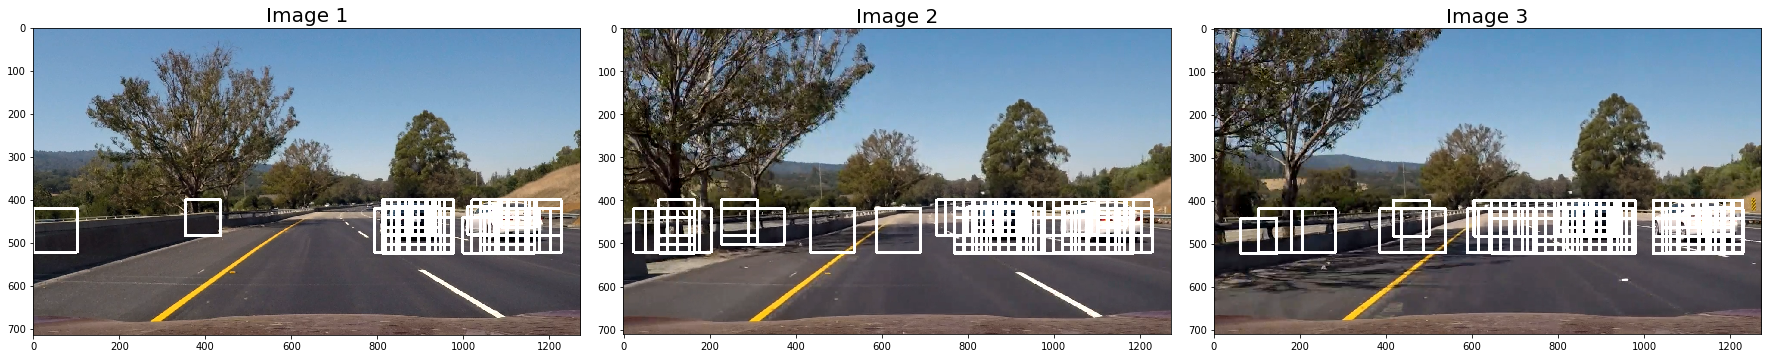

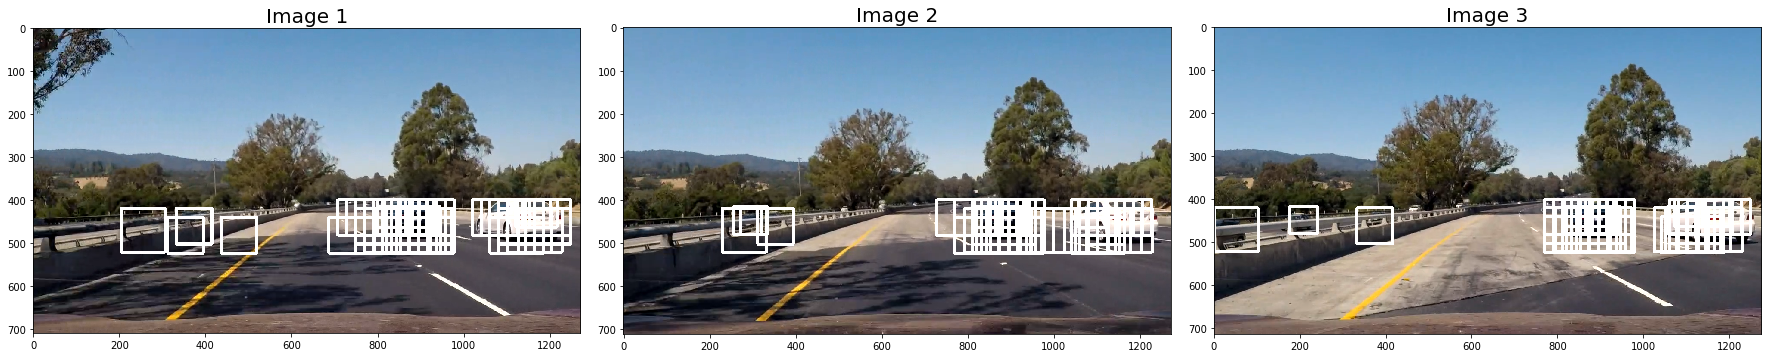

In [390]:
def apply_sliding_window(image, svc, X_scaler, pix_per_cell, cell_per_block, spatial_size, hist_bins):
    bboxes = []
    ystart = 400
    ystop = 500 
    out_img, bboxes1 = find_cars(image, ystart, ystop, 1.0, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)
    ystart = 400
    ystop = 500 
    out_img, bboxes2 = find_cars(out_img, ystart, ystop, 1.3, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)
    ystart = 410
    ystop = 500 
    out_img, bboxes3 = find_cars(out_img, ystart, ystop, 1.4, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)
    ystart = 420
    ystop = 556 
    out_img, bboxes4 = find_cars(out_img, ystart, ystop, 1.6, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)
    ystart = 430
    ystop = 556 
    out_img, bboxes5 = find_cars (out_img, ystart, ystop, 1.8, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)
    ystart = 430
    ystop = 556 
    out_img, bboxes6 = find_cars (out_img, ystart, ystop, 2.0, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)
    ystart = 440
    ystop = 556 
    out_img, bboxes7 = find_cars (out_img, ystart, ystop, 1.9, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)
    ystart = 400
    ystop = 556 
    out_img, bboxes8 = find_cars (out_img, ystart, ystop, 1.3, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)
    ystart = 400
    ystop = 556 
    out_img, bboxes9 = find_cars (out_img, ystart, ystop, 2.2, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)
    ystart = 500 
    ystop = 656 
    out_img, bboxes10 = find_cars (out_img, ystart, ystop, 3.0, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)
    bboxes.extend(bboxes1)
    bboxes.extend(bboxes2)
    bboxes.extend(bboxes3)
    bboxes.extend(bboxes4)
    bboxes.extend(bboxes5)
    bboxes.extend(bboxes6)
    bboxes.extend(bboxes7)
    bboxes.extend(bboxes8)
    bboxes.extend(bboxes9)
    bboxes.extend(bboxes10)
    
    return out_img, bboxes
   
image1 = mpimg.imread('./test_series/series1.jpg')
image2 = mpimg.imread('./test_series/series2.jpg')
image3 = mpimg.imread('./test_series/series3.jpg')
image4 = mpimg.imread('./test_series/series4.jpg')
image5 = mpimg.imread('./test_series/series5.jpg')
image6 = mpimg.imread('./test_series/series6.jpg')

output_image1, bboxes1 = apply_sliding_window(image1, svc, X_scaler, pix_per_cell, cell_per_block, spatial_size, hist_bins)
output_image2, bboxes2 = apply_sliding_window(image2, svc, X_scaler, pix_per_cell, cell_per_block, spatial_size, hist_bins)
output_image3, bboxes3 = apply_sliding_window(image3, svc, X_scaler, pix_per_cell, cell_per_block, spatial_size, hist_bins)
output_image4, bboxes4 = apply_sliding_window(image4, svc, X_scaler, pix_per_cell, cell_per_block, spatial_size, hist_bins)
output_image5, bboxes5 = apply_sliding_window(image5, svc, X_scaler, pix_per_cell, cell_per_block, spatial_size, hist_bins)
output_image6, bboxes6 = apply_sliding_window(image6, svc, X_scaler, pix_per_cell, cell_per_block, spatial_size, hist_bins)

image = mpimg.imread('./test_images/test4.jpg')
draw_image = np.copy(image)
output_image, bboxes = apply_sliding_window(image, svc, X_scaler, pix_per_cell, cell_per_block, spatial_size, hist_bins)

def show_images(image1, image2, image3,  image1_exp="Image 1", image2_exp="Image 2", image3_exp="Image 3"):
    f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(24, 9))
    f.tight_layout()
    ax1.imshow(image1)
    ax1.set_title(image1_exp, fontsize=20)
    ax2.imshow(image2)
    ax2.set_title(image2_exp, fontsize=20)
    ax3.imshow(image3)
    ax3.set_title(image3_exp, fontsize=20)
    plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

show_images(output_image1, output_image2, output_image3)
show_images(output_image4, output_image5, output_image6)

## Heatmap
* combine overlapping detections
* remove false positives

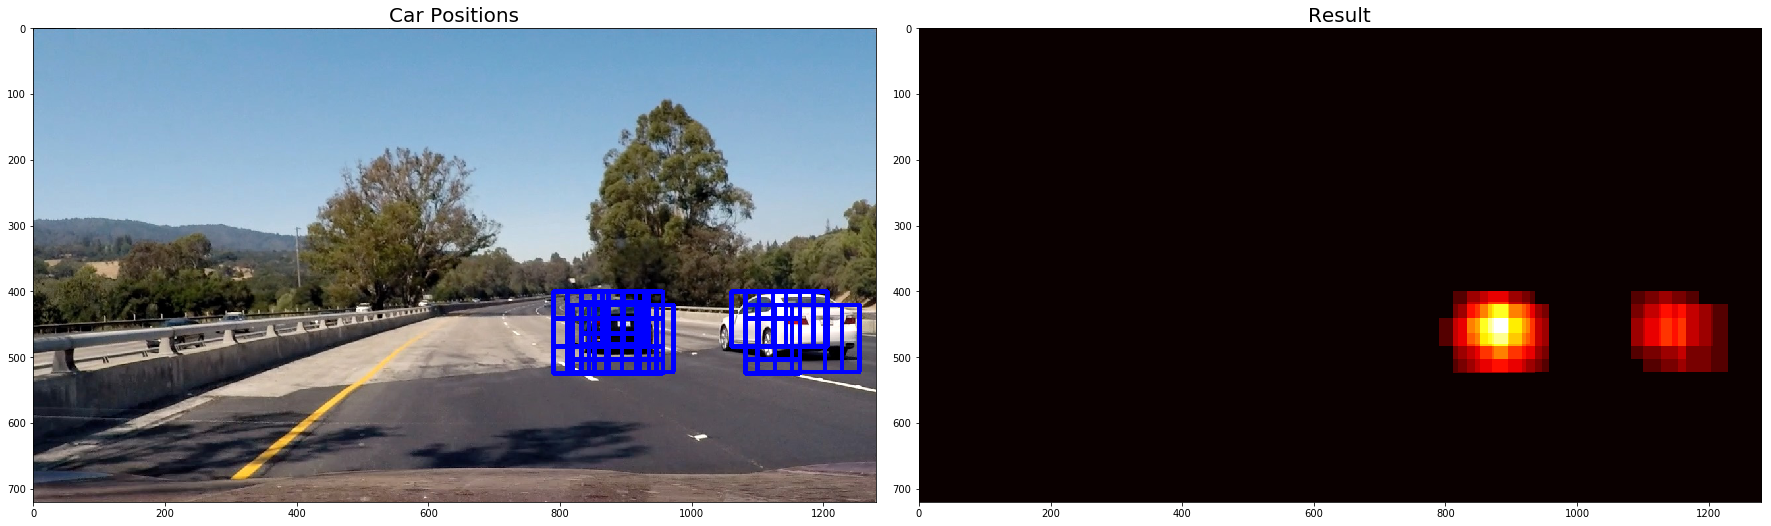

In [386]:
from scipy.ndimage.measurements import label

def add_heat(heatmap, bbox_list):
    # Iterate through list of bboxes
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1

    # Return updated heatmap
    return heatmap# Iterate through list of bboxes
    
def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    # Return thresholded map
    return heatmap

def draw_labeled_bboxes(img, labels):
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        # Draw the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)
    # Return the image
    return img

heat = np.zeros_like(output_image[:,:,0]).astype(np.float)
# Add heat to each box in box list
heat = add_heat(heat, bboxes)
    
# Apply threshold to help remove false positives
threshold = 1 
heat = apply_threshold(heat, threshold)

# Visualize the heatmap when displaying    
heatmap = np.clip(heat, 0, 255)

# Find final boxes from heatmap using label function
labels = label(heatmap)
draw_img = draw_labeled_bboxes(np.copy(image), labels)

def show_images(image1, image2,  image1_exp="Image 1", image2_exp="Image 2"):
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
    f.tight_layout()
    ax1.imshow(image1)
    ax1.set_title(image1_exp, fontsize=20)
    ax2.imshow(image2, cmap='hot')
    ax2.set_title(image2_exp, fontsize=20)
    plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
    
show_images(output_image, heatmap, "Car Positions", "Result")

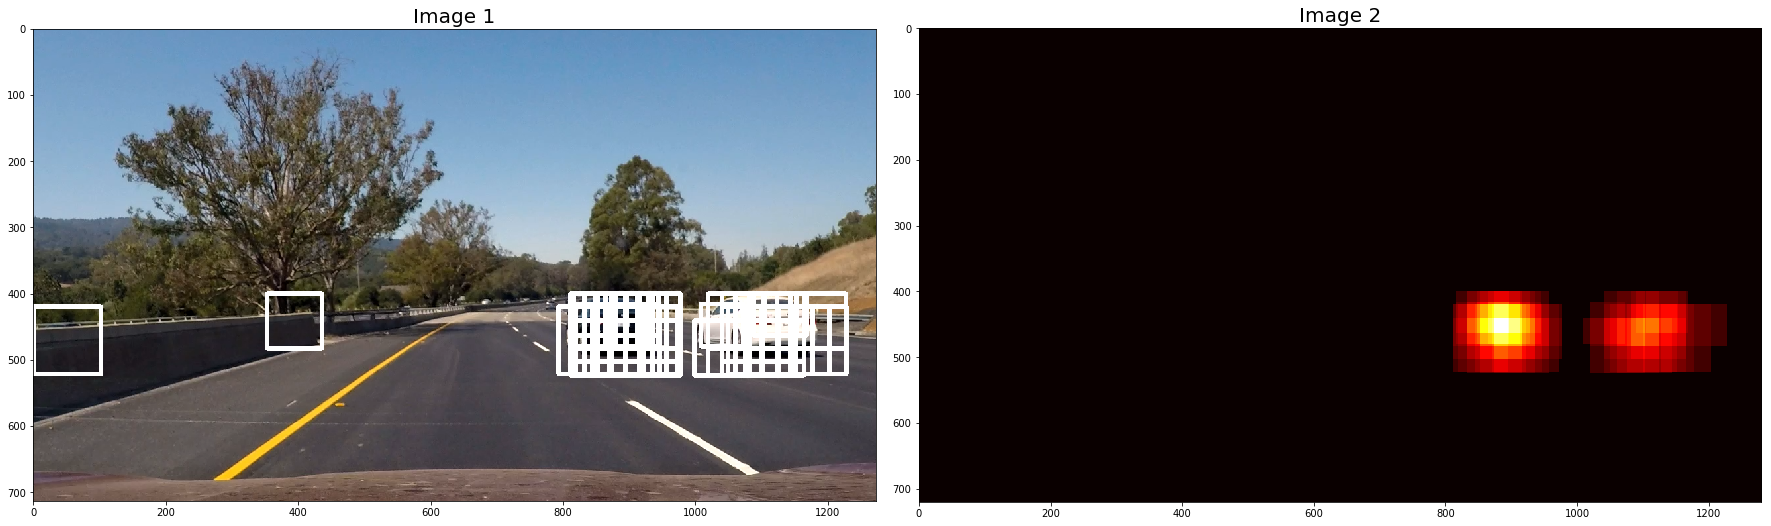

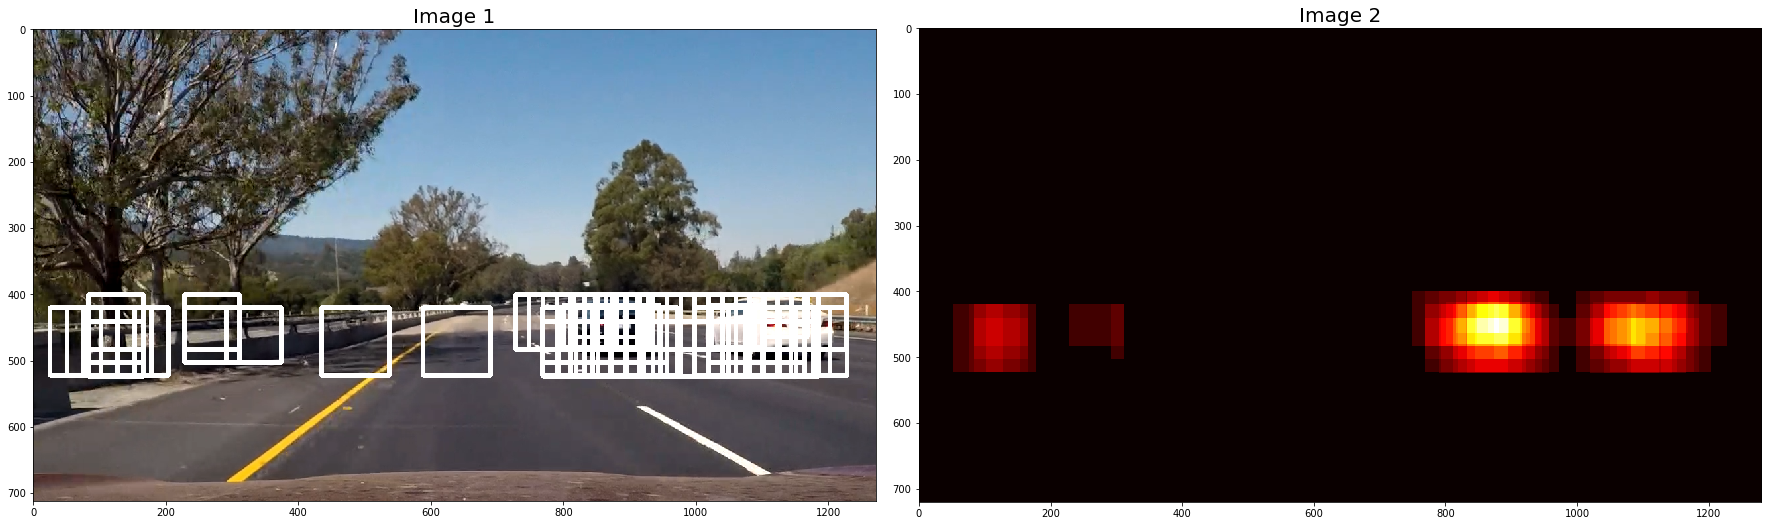

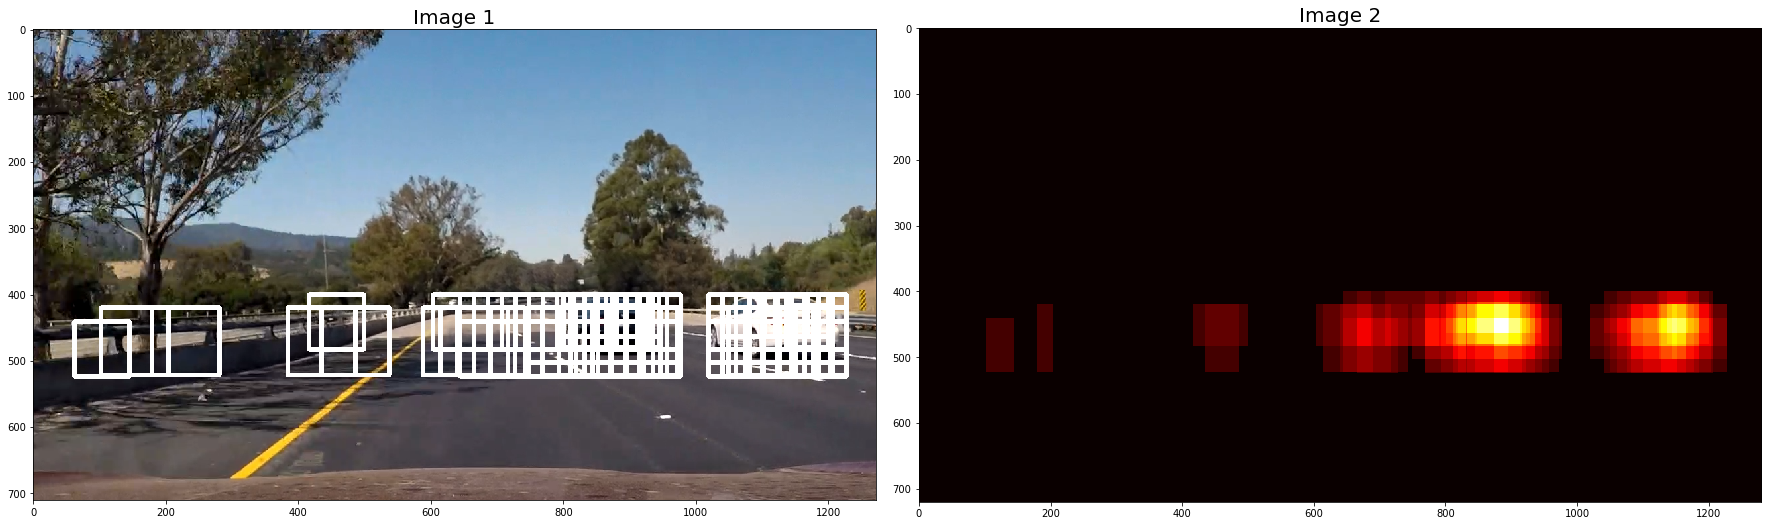

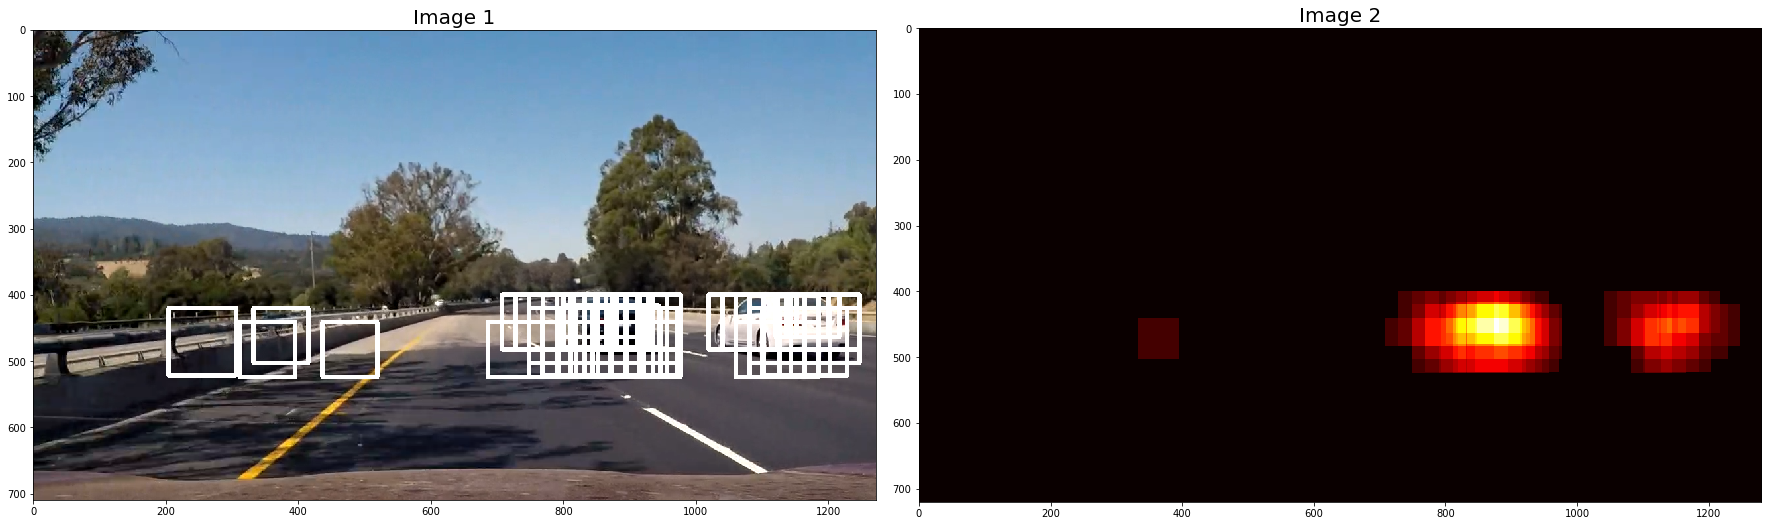

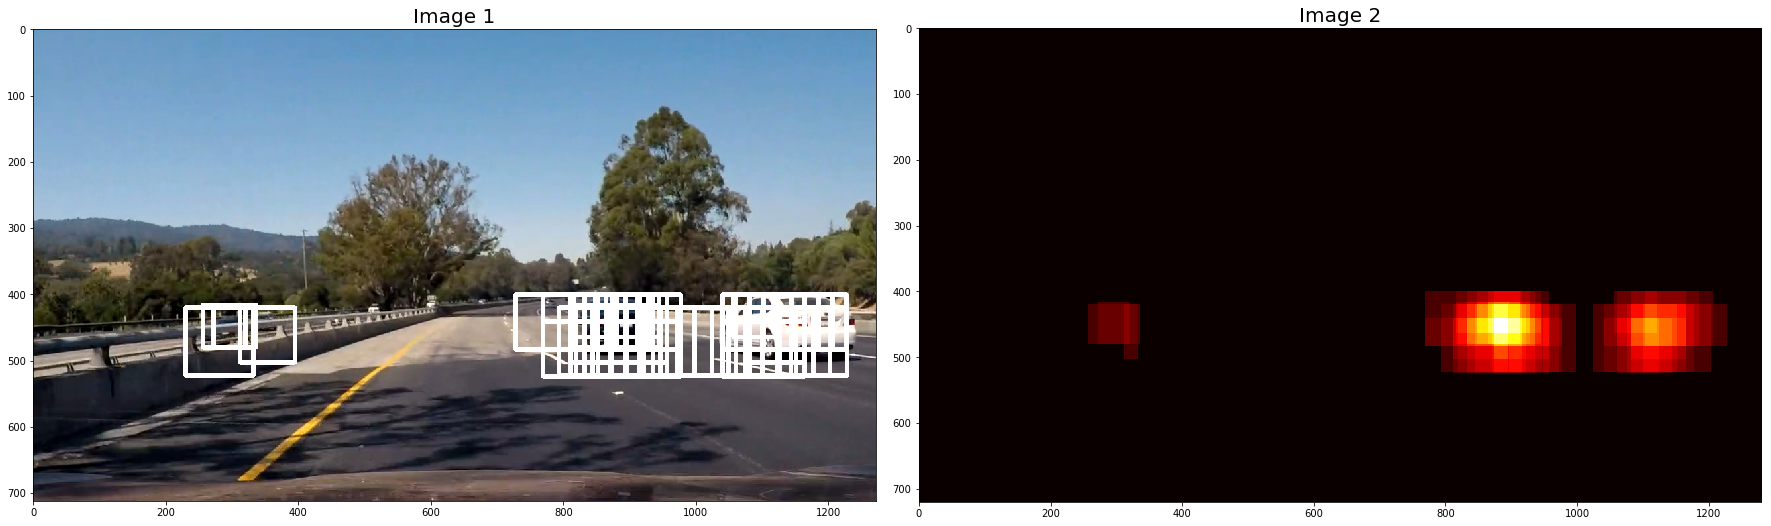

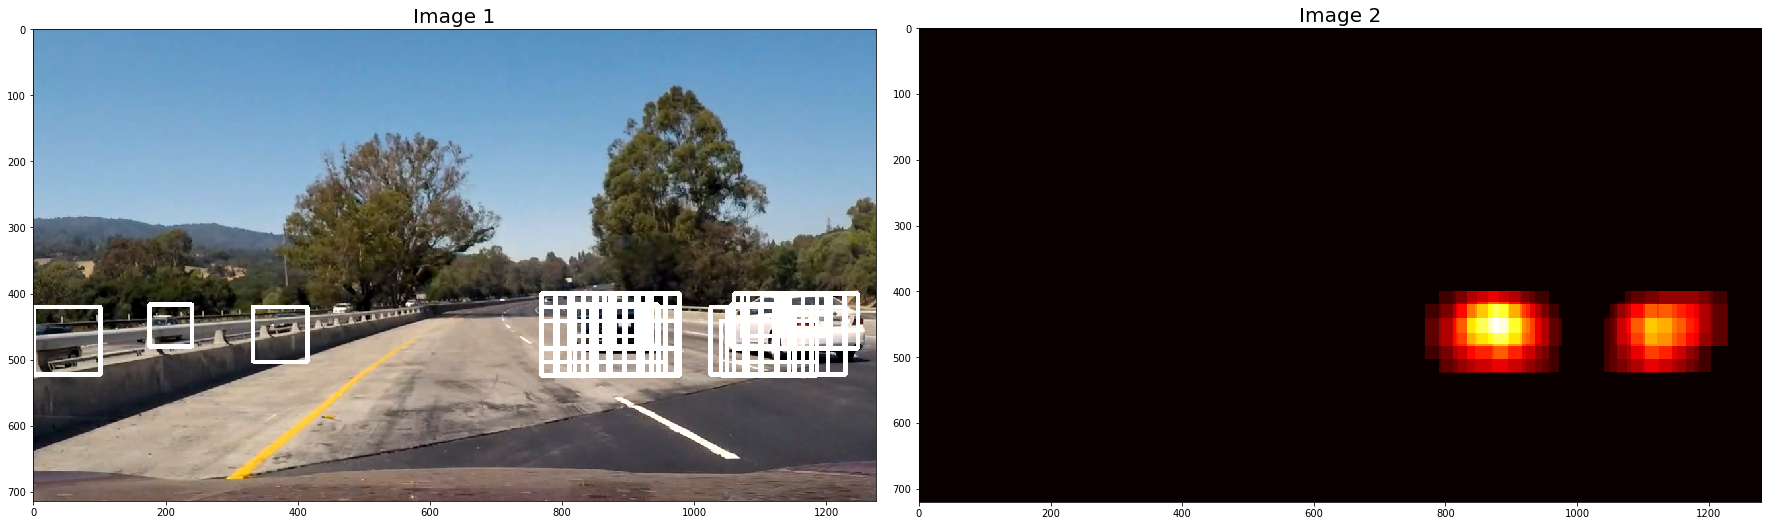

In [391]:
def get_heatmap(bboxes):
    threshold = 1
    heat = np.zeros_like(output_image[:,:,0]).astype(np.float) 
    heat = add_heat(heat, bboxes)
    heat = apply_threshold(heat, threshold)
    heatmap = np.clip(heat, 0, 255)
    return heatmap

def show_images(image1, image2,  image1_exp="Image 1", image2_exp="Image 2"):
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
    f.tight_layout()
    ax1.imshow(image1)
    ax1.set_title(image1_exp, fontsize=20)
    ax2.imshow(image2, cmap='hot')
    ax2.set_title(image2_exp, fontsize=20)
    plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

heatmap1 = get_heatmap(bboxes1)
heatmap2 = get_heatmap(bboxes2)
heatmap3 = get_heatmap(bboxes3)
heatmap4 = get_heatmap(bboxes4)
heatmap5 = get_heatmap(bboxes5)
heatmap6 = get_heatmap(bboxes6)
show_images(output_image1, heatmap1)
show_images(output_image2, heatmap2)
show_images(output_image3, heatmap3)
show_images(output_image4, heatmap4)
show_images(output_image5, heatmap5)
show_images(output_image6, heatmap6)

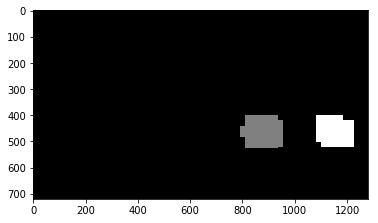

In [392]:
plt.imshow(labels[0], cmap='gray')

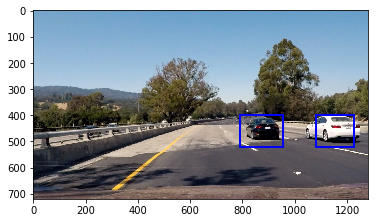

In [393]:
plt.imshow(draw_img)

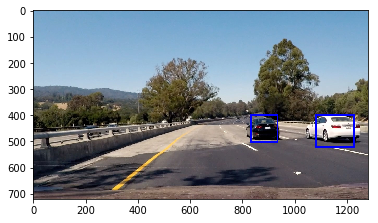

In [397]:
from collections import deque
history = deque(maxlen = 8)

def detect_cars(image):
    bboxes = []
    ystart = 400
    ystop = 500 
    out_img, bboxes1 = find_cars(image, ystart, ystop, 1.0, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)
    ystart = 400
    ystop = 500 
    out_img, bboxes2 = find_cars(image, ystart, ystop, 1.3, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)
    ystart = 410
    ystop = 500 
    out_img, bboxes3 = find_cars(out_img, ystart, ystop, 1.4, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)
    ystart = 420
    ystop = 556 
    out_img, bboxes4 = find_cars(out_img, ystart, ystop, 1.6, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)
    ystart = 430
    ystop = 556 
    out_img, bboxes5 = find_cars (out_img, ystart, ystop, 1.8, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)
    ystart = 430
    ystop = 556 
    out_img, bboxes6 = find_cars (out_img, ystart, ystop, 2.0, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)
    ystart = 440
    ystop = 556 
    out_img, bboxes7 = find_cars (out_img, ystart, ystop, 1.9, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)
    ystart = 400
    ystop = 556 
    out_img, bboxes8 = find_cars (out_img, ystart, ystop, 1.3, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)
    ystart = 400
    ystop = 556 
    out_img, bboxes9 = find_cars (out_img, ystart, ystop, 2.2, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)
    ystart = 500 
    ystop = 656 
    out_img, bboxes10 = find_cars (out_img, ystart, ystop, 3.0, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)
    bboxes.extend(bboxes1)
    bboxes.extend(bboxes2)
    bboxes.extend(bboxes3)
    bboxes.extend(bboxes4)
    bboxes.extend(bboxes5)
    bboxes.extend(bboxes6)
    bboxes.extend(bboxes7)
    bboxes.extend(bboxes8)
    bboxes.extend(bboxes9)
    bboxes.extend(bboxes10)
   
    heat = np.zeros_like(out_img[:,:,0]).astype(np.float)
    # Add heat to each box in box list
    heat = add_heat(heat, bboxes)

    # Apply threshold to help remove false positives
    threshold = 1
    heat = apply_threshold(heat, threshold)

    # Visualize the heatmap when displaying    
    current_heatmap = np.clip(heat, 0, 255)
    history.append(current_heatmap)
    
    heatmap = np.zeros_like(current_heatmap).astype(np.float)
    for heat in history:
        heatmap = heatmap + heat

    # Find final boxes from heatmap using label function
    labels = label(heatmap)
    draw_img = draw_labeled_bboxes(np.copy(image), labels)
    
    return draw_img
    
img = detect_cars(image)
plt.imshow(img)

## Video processing

In [398]:
from moviepy.editor import VideoFileClip

In [399]:
output = 'test_result.mp4'
clip = VideoFileClip("test_video.mp4")
video_clip = clip.fl_image(detect_cars)
%time video_clip.write_videofile(output, audio=False)


[MoviePy] >>>> Building video test_result.mp4
[MoviePy] Writing video test_result.mp4


 97%|████████████████████████████████████████▉ | 38/39 [00:43<00:01,  1.13s/it]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_result.mp4 

Wall time: 44.7 s


In [227]:
def draw_line(img, lines, color = (255, 0, 0), thickness = 5):
    """
    Draw a line on image
    
    parameter:
    
    -- img: uint8, ndarray
           A 2-D or 3-D tensor
    -- pts: list of pts
           The starting point and end point of a line: [x1,y1,x2,y2]
    -- color: tuples with three ints
           The color of the line
    -- thickness: int
           The line thickness
    
    return:
    
    -- img: uint8, ndarray
           image with the line
    """
    cp_img = np.copy(img)
    for i in lines:
        cv2.line(cp_img, (i[0], i[1]), (i[2], i[3]), color, thickness)
    return cp_img

In [229]:
test_videos_dir = 'videos//test_input'
test_videos = [os.path.join(test_videos_dir, name) for name in os.listdir(test_videos_dir)]
for test_video in test_videos:
    print('Processing video: {}'.format(test_video))
    cap = cv2.VideoCapture(test_video)  
    
    # get video frame size
    width, height = 0, 0
    if cap.isOpened(): 
        width = int(cap.get(3))
        height = int(cap.get(4)) 

    # initialize video writer object
    out_Video = cv2.VideoWriter(os.path.join('videos//test_output', "processed_" + os.path.basename(test_video)),
                      fourcc=cv2.VideoWriter_fourcc(*'DIVX'),
                      fps=24.0, frameSize=(width, height))
    in_image = None
    try:
        while cap.isOpened():
            # cap.read() returns a bool (True/False). 
            # If frame is read correctly, it will be True. 
            # End of the video can be checked with this return value.
            ret, color_frame = cap.read()
            if ret:
                input_img = cv2.cvtColor(color_frame, cv2.COLOR_BGR2RGB)
                height, width, _ = input_img.shape
                midLine_img = draw_line(color_frame, lines = [[0, height//2, width, height//2]], color = (255, 0, 0), thickness = 5)       
                out_Video.write(midLine_img)
            else:
                break
        print ("transform ends")        
    finally:
        cap.release()
        out_Video.release()
        cv2.destroyAllWindows()

Processing video: videos//test_input\test_video.mp4
transform ends


----------------
# Test

In [225]:
houghLine_para = { "rho": 1
                , "theta": np.pi/180
                , "threshold": 50
                , "min_line_len": 100
                , "max_line_gap": 160}

rho = houghLine_para["rho"]
theta = houghLine_para["theta"]
threshold = houghLine_para["threshold"]
min_line_len = houghLine_para["min_line_len"]
max_line_gap = houghLine_para["max_line_gap"]
test_img_path = ".//test_images//test1.jpg"
BGR_img = mpimg.imread(test_img_path)
RGB_img = cv2.cvtColor(BGR_img, cv2.COLOR_BGR2RGB)
gray_img = cv2.cvtColor(RGB_img, cv2.COLOR_RGB2GRAY)

lower_half_img = RGB_img[RGB_img.shape[0]//2:,:,:]

gauss_img = cv2.GaussianBlur(lower_half_img,(7,7),0)  
edges = cv2.Canny(gauss_img, 100, 170, apertureSize = 3)  


hough_lines = np.squeeze(cv2.HoughLinesP(edges, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap), axis=1)

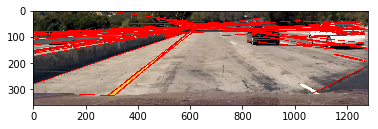

In [226]:
a = draw_line(lower_half_img, hough_lines, color = (255, 0, 0), thickness = 2)
plt.imshow(a)

##### histogram

In [537]:
test_img_path = ".//test_images//test1.jpg"
BGR_img = mpimg.imread(test_img_path)
RGB_img = cv2.cvtColor(BGR_img, cv2.COLOR_BGR2RGB)

rhist = np.histogram(image[:,:,0], bins=32, range=(0, 256))
ghist = np.histogram(image[:,:,1], bins=32, range=(0, 256))
bhist = np.histogram(image[:,:,2], bins=32, range=(0, 256))

In [538]:
# Generating bin centers
bin_edges = rhist[1]
bin_centers = (bin_edges[1:]  + bin_edges[0:len(bin_edges)-1])/2

Text(0.5,1,'B Histogram')

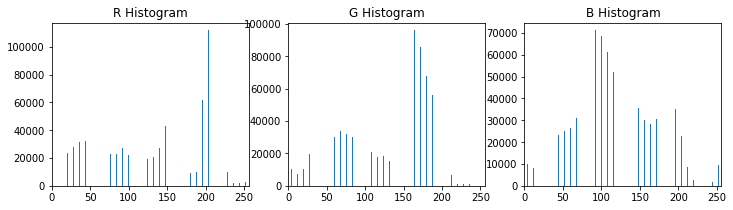

In [539]:
# Plot a figure with all three bar charts
fig = plt.figure(figsize=(12,3))
plt.subplot(131)
plt.bar(bin_centers, rhist[0])
plt.xlim(0, 256)
plt.title('R Histogram')
plt.subplot(132)
plt.bar(bin_centers, ghist[0])
plt.xlim(0, 256)
plt.title('G Histogram')
plt.subplot(133)
plt.bar(bin_centers, bhist[0])
plt.xlim(0, 256)
plt.title('B Histogram')

In [540]:
def test_color_hist(img, nbins=32, bins_range=(0, 256)):
    # Compute the histogram of the RGB channels separately
    rhist = np.histogram(img[:,:,0], bins=nbins, range=bins_range)
    ghist = np.histogram(img[:,:,1], bins=nbins, range=bins_range)
    bhist = np.histogram(img[:,:,2], bins=nbins, range=bins_range)
    # Generating bin centers
    bin_edges = rhist[1]
    bin_centers = (bin_edges[1:]  + bin_edges[0:len(bin_edges)-1])/2
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((rhist[0], ghist[0], bhist[0]))
    # Return the individual histograms, bin_centers and feature vector
    return rhist, ghist, bhist, bin_centers, hist_features

In [ ]:
# Define a function you will pass an image 
# and the list of windows to be searched (output of slide_windows())
def search_windows(img, windows, clf, scaler, color_space='RGB', 
                    spatial_size=(32, 32), hist_bins=32, 
                    hist_range=(0, 256), orient=9, 
                    pix_per_cell=8, cell_per_block=2, 
                    hog_channel=0, spatial_feat=True, 
                    hist_feat=True, hog_feat=True):
    """
    This method extracts features from a image based on the list of windows to be searched (output of slide_windows())
    
    parameter:
    
    -- img: uint8, ndarray
           A 2-D, 3-D tensor.
           
    -- clf: classifier object
           predict if the vehicle is in a box
           
    --- scaler: scikit-learn scaler object
           rescale the feature to the range between 0 and 1.
           
    -- windows: list
           List of windows to be searched
             
    * Returns
    
    -- detected_windows: list
           A list of windows which found the target.
    """  
    #1) Create an empty list to receive positive detection windows
    on_windows = []
    #2) Iterate over all windows in the list
    for window in windows:
        #3) Extract the test window from original image
        test_img = cv2.resize(img[window[0][1]:window[1][1], window[0][0]:window[1][0]]
                    , (64, 64))      
        #4) Extract features for that window using single_img_features()
        spatial_f, color_hist_f, HOG_f = get_img_features(img = test_img
                                                    , spatial_feat = spatial_feat, hist_feat = hist_feat, hog_feat = hog_feat
                                                    , hist_bins = hist_bins
                                                    , spatial_size = spatial_size
                                                    , orient = orient , pix_per_cell = pix_per_cell, cell_per_block = cell_per_block
                                                    , hog_channel = hog_channel, color_space=color_space)

        features = np.concatenate((spatial_f.ravel(), color_hist_f.ravel(), HOG_f.ravel()))
        #5) Scale extracted features to be fed to classifier
        test_features = scaler.transform(features.reshape(1, -1))
        #6) Predict using your classifier
        prediction = clf.predict(test_features)
        #7) If positive (prediction == 1) then save the window
        if prediction == 1:
            on_windows.append(window)
    #8) Return windows for positive detections
    return on_windows